In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 10

In [5]:
seed = 3121
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  W9TG7ZON_05_05_45
NN-MODEL FILENAME:  ./models/W9TG7ZON_05_05_45_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-4  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 300000

In [11]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 15000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  30


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration+1)*0.15) ,0.3,0.97)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
        
    my_LR        = T_LR
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, -1).astype(np.float16)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1304.49 MiB, increment: 1084.53 MiB
Quantization TIME:  0.02 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
SMALLEST TIMESTEP in ITERATION 0: 9
REAL TIME TO GENERATE 22670 EXPERIENCES:0:00:01.077271


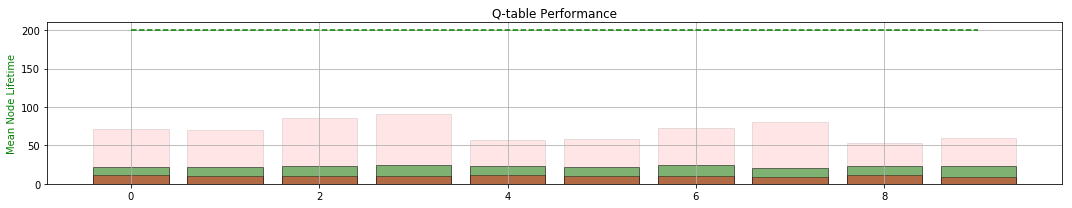

MEMORY COUNTER:  22670
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 4.821	LOSS : 5.649	LOSS : 5.511	LOSS : 5.502	LOSS : 5.905	LOSS : 5.005	LOSS : 5.782	LOSS : 4.915	LOSS : 4.922	LOSS : 5.058	LOSS : 5.376	LOSS : 5.111	LOSS : 5.704	LOSS : 5.077	LOSS : 5.555	LOSS : 5.309	LOSS : 4.763	LOSS : 5.088	LOSS : 4.562	LOSS : 4.777	LOSS : 5.118	LOSS : 5.277	LOSS : 4.573	LOSS : 5.449	LOSS : 5.223	LOSS : 4.772	LOSS : 5.429	LOSS : 5.500	LOSS : 5.374	LOSS : 5.031	
Validating... MEAN TIME:  27.5
LOSS : 4.881	LOSS : 4.905	LOSS : 5.476	LOSS : 4.722	LOSS : 4.932	LOSS : 5.464	LOSS : 5.429	LOSS : 4.934	LOSS : 4.938	LOSS : 5.089	LOSS : 5.402	LOSS : 4.987	LOSS : 5.017	LOSS : 4.920	LOSS : 4.902	LOSS : 4.896	LOSS : 5.092	LOSS : 5.361	LOSS : 4.890	LOSS : 5.447	LOSS : 5.234	LOSS : 5.174	LOSS : 5.055	LOSS : 4.809	LOSS : 4.762	LOSS : 4.671	LOSS : 4.981	LOSS : 4.908	LOSS : 4.825	LOSS : 4.953	
Validating... MEAN TIME:  9.35
LOSS : 4.586	LOSS : 4.753	L

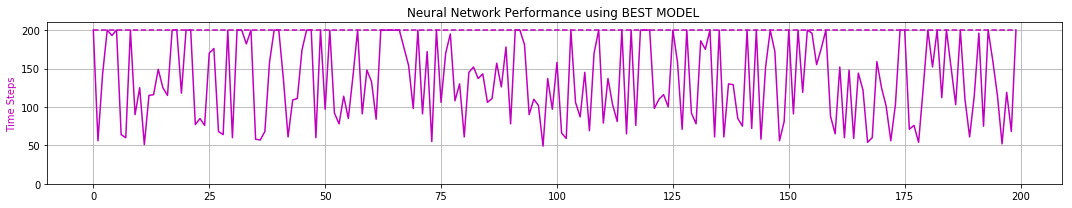

peak memory: 1348.50 MiB, increment: 1036.52 MiB
0 -max- [ 0.221  1.224  0.209  2.183]
0 -min- [-0.097 -1.386 -0.209 -2.108]

1 -max- [ 0.182  1.215  0.208  1.443]
1 -min- [-0.113 -0.995 -0.209 -2.004]

2 -max- [ 0.209  1.173  0.209  1.633]
2 -min- [-0.048 -0.946 -0.209 -1.801]

3 -max- [ 0.192  1.354  0.209  1.598]
3 -min- [-0.086 -0.928 -0.209 -2.150]

4 -max- [ 0.204  1.527  0.202  1.775]
4 -min- [-0.076 -0.815 -0.209 -2.427]

5 -max- [ 0.195  1.229  0.206  1.762]
5 -min- [-0.072 -0.975 -0.209 -2.175]

6 -max- [ 0.211  1.384  0.208  2.141]
6 -min- [-0.050 -1.119 -0.209 -2.232]

7 -max- [ 0.190  1.373  0.198  1.424]
7 -min- [-0.051 -0.763 -0.209 -2.233]

8 -max- [ 0.193  1.152  0.208  1.725]
8 -min- [-0.091 -1.152 -0.209 -1.806]

9 -max- [ 0.196  1.347  0.209  1.793]
9 -min- [-0.125 -0.961 -0.209 -2.061]

Quantization TIME:  0.02 minutes


ITERATION # 1
SMALLEST TIMESTEP in ITERATION 1: 15
REAL TIME TO GENERATE 70596 EXPERIENCES:0:00:01.720401


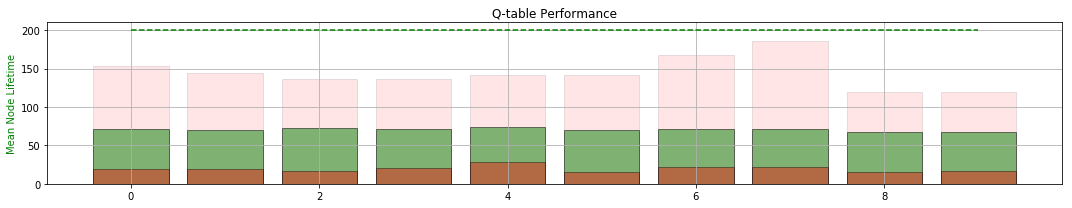

MEMORY COUNTER:  93266
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.913	LOSS : 2.650	LOSS : 3.017	LOSS : 2.970	LOSS : 2.923	LOSS : 3.007	LOSS : 2.657	LOSS : 2.955	LOSS : 2.563	LOSS : 2.785	LOSS : 2.648	LOSS : 3.021	LOSS : 2.729	LOSS : 2.651	LOSS : 2.969	LOSS : 2.974	LOSS : 2.891	LOSS : 2.520	LOSS : 2.713	LOSS : 2.132	LOSS : 2.595	LOSS : 2.834	LOSS : 2.757	LOSS : 2.412	LOSS : 2.113	LOSS : 2.525	LOSS : 2.338	LOSS : 2.239	LOSS : 2.584	LOSS : 2.537	
Validating... MEAN TIME:  90.98
LOSS : 2.557	LOSS : 2.301	LOSS : 2.327	LOSS : 2.441	LOSS : 2.227	LOSS : 2.373	LOSS : 2.934	LOSS : 3.073	LOSS : 2.755	LOSS : 2.401	LOSS : 2.711	LOSS : 2.648	LOSS : 2.793	LOSS : 2.166	LOSS : 2.343	LOSS : 2.463	LOSS : 2.093	LOSS : 2.125	LOSS : 2.592	LOSS : 2.366	LOSS : 2.399	LOSS : 2.135	LOSS : 2.209	LOSS : 2.408	LOSS : 2.774	LOSS : 2.284	LOSS : 2.512	LOSS : 2.337	LOSS : 2.138	LOSS : 2.189	
Validating... MEAN TIME:  139.685
LOSS : 1.994	LOSS : 2.4

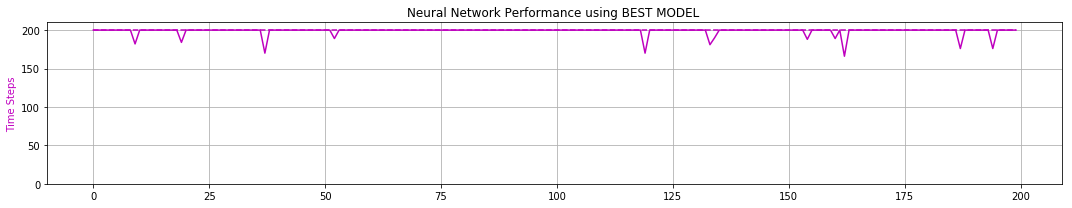

peak memory: 1377.66 MiB, increment: 1046.41 MiB
0 -max- [ 0.316  0.965  0.209  2.035]
0 -min- [-0.933 -1.688 -0.209 -1.604]

1 -max- [ 0.299  0.943  0.209  1.227]
1 -min- [-0.809 -1.680 -0.209 -1.312]

2 -max- [ 0.310  1.058  0.209  1.637]
2 -min- [-0.945 -1.923 -0.209 -1.589]

3 -max- [ 0.370  0.987  0.209  1.083]
3 -min- [-0.847 -1.819 -0.209 -1.708]

4 -max- [ 0.408  1.093  0.208  1.271]
4 -min- [-0.912 -1.887 -0.209 -1.251]

5 -max- [ 0.338  1.083  0.209  1.406]
5 -min- [-0.912 -1.801 -0.209 -1.678]

6 -max- [ 0.288  1.123  0.209  1.569]
6 -min- [-1.022 -1.819 -0.209 -1.494]

7 -max- [ 0.400  1.127  0.209  1.148]
7 -min- [-0.862 -1.680 -0.209 -1.586]

8 -max- [ 0.372  1.075  0.209  1.481]
8 -min- [-0.816 -1.532 -0.209 -1.738]

9 -max- [ 0.366  1.258  0.209  1.444]
9 -min- [-1.270 -2.046 -0.209 -1.809]

Quantization TIME:  0.01 minutes


ITERATION # 2
SMALLEST TIMESTEP in ITERATION 2: 15
REAL TIME TO GENERATE 146047 EXPERIENCES:0:00:03.827364


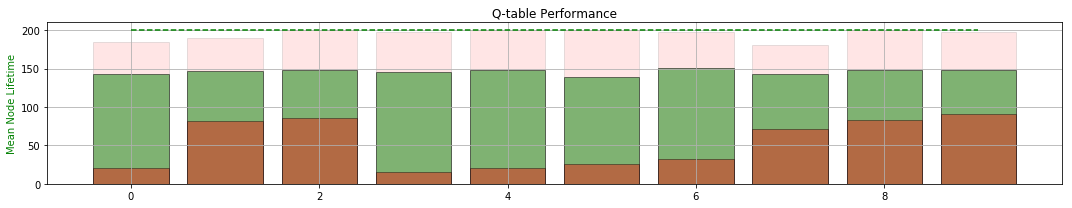

MEMORY COUNTER:  239313
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.567	LOSS : 1.508	LOSS : 1.442	LOSS : 1.736	LOSS : 1.357	LOSS : 1.324	LOSS : 1.631	LOSS : 1.411	LOSS : 1.190	LOSS : 1.307	LOSS : 2.010	LOSS : 1.826	LOSS : 1.706	LOSS : 1.751	LOSS : 1.946	LOSS : 1.799	LOSS : 1.552	LOSS : 1.384	LOSS : 1.390	LOSS : 1.458	LOSS : 1.768	LOSS : 1.581	LOSS : 1.439	LOSS : 2.189	LOSS : 1.170	LOSS : 1.652	LOSS : 1.304	LOSS : 1.462	LOSS : 1.320	LOSS : 1.580	
Validating... MEAN TIME:  160.98
LOSS : 1.465	LOSS : 1.747	LOSS : 1.757	LOSS : 1.513	LOSS : 1.354	LOSS : 1.153	LOSS : 1.320	LOSS : 1.716	LOSS : 1.650	LOSS : 1.492	LOSS : 1.503	LOSS : 1.229	LOSS : 1.267	LOSS : 1.242	LOSS : 1.408	LOSS : 1.501	LOSS : 1.560	LOSS : 1.712	LOSS : 1.435	LOSS : 1.643	LOSS : 1.548	LOSS : 1.616	LOSS : 1.535	LOSS : 1.234	LOSS : 1.664	LOSS : 1.495	LOSS : 1.459	LOSS : 1.575	LOSS : 1.426	LOSS : 1.371	
Validating... MEAN TIME:  173.675
LOSS : 1.611	LOSS : 1

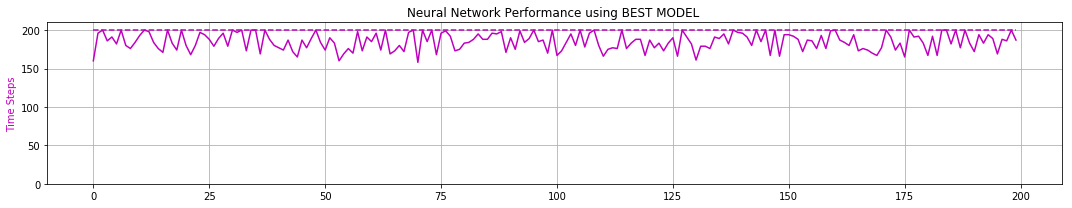

peak memory: 1434.55 MiB, increment: 1047.66 MiB
0 -max- [ 0.148  1.059  0.206  1.580]
0 -min- [-2.400 -2.783 -0.209 -2.907]

1 -max- [ 0.169  1.194  0.209  1.567]
1 -min- [-2.399 -2.771 -0.209 -2.714]

2 -max- [ 0.293  1.556  0.207  1.641]
2 -min- [-2.398 -2.835 -0.209 -3.227]

3 -max- [ 0.134  1.013  0.205  1.894]
3 -min- [-2.399 -2.818 -0.209 -2.554]

4 -max- [ 0.211  1.050  0.203  1.670]
4 -min- [-2.400 -2.658 -0.209 -2.813]

5 -max- [ 0.194  0.819  0.204  1.668]
5 -min- [-2.399 -2.996 -0.209 -2.257]

6 -max- [ 0.140  1.076  0.203  1.589]
6 -min- [-2.399 -2.666 -0.209 -2.864]

7 -max- [ 0.186  1.204  0.208  1.593]
7 -min- [-2.399 -2.798 -0.209 -2.826]

8 -max- [ 0.250  0.832  0.209  1.864]
8 -min- [-2.400 -2.850 -0.209 -2.263]

9 -max- [ 0.162  1.142  0.208  2.629]
9 -min- [-2.397 -2.855 -0.209 -2.574]

Quantization TIME:  0.01 minutes


ITERATION # 3
SMALLEST TIMESTEP in ITERATION 3: 21
REAL TIME TO GENERATE 111711 EXPERIENCES:0:00:02.879916


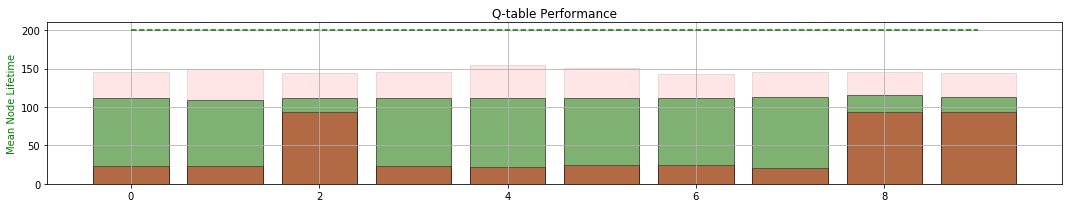

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.114	LOSS : 1.044	LOSS : 0.949	LOSS : 1.078	LOSS : 1.133	LOSS : 1.185	LOSS : 1.094	LOSS : 1.016	LOSS : 1.183	LOSS : 1.151	LOSS : 1.102	LOSS : 0.969	LOSS : 0.881	LOSS : 0.888	LOSS : 0.913	LOSS : 1.155	LOSS : 1.245	LOSS : 1.122	LOSS : 1.148	LOSS : 1.023	LOSS : 1.285	LOSS : 0.949	LOSS : 1.454	LOSS : 1.101	LOSS : 0.875	LOSS : 1.435	LOSS : 0.913	LOSS : 0.899	LOSS : 0.813	LOSS : 0.931	
Validating... MEAN TIME:  167.51
LOSS : 1.003	LOSS : 0.903	LOSS : 0.970	LOSS : 1.051	LOSS : 0.894	LOSS : 1.019	LOSS : 0.973	LOSS : 0.933	LOSS : 1.039	LOSS : 1.093	LOSS : 0.759	LOSS : 0.830	LOSS : 1.104	LOSS : 1.102	LOSS : 1.214	LOSS : 1.020	LOSS : 0.970	LOSS : 1.268	LOSS : 1.133	LOSS : 1.102	LOSS : 1.030	LOSS : 1.119	LOSS : 0.942	LOSS : 1.035	LOSS : 1.047	LOSS : 1.108	LOSS : 0.849	LOSS : 1.229	LOSS : 1.038	LOSS : 0.935	
Validating... MEAN TIME:  180.41
LOSS : 1.111	LOSS : 0.9

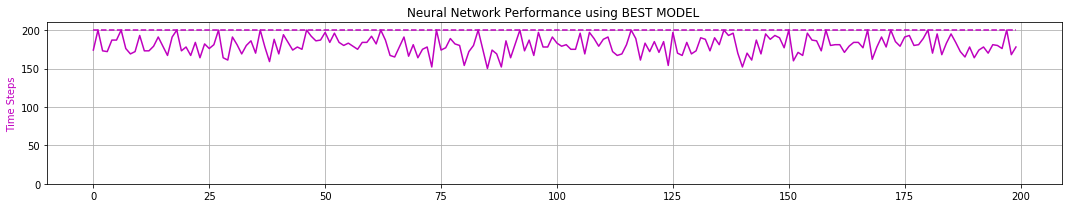

peak memory: 1458.09 MiB, increment: 1006.03 MiB
0 -max- [ 0.136  0.813  0.166  1.610]
0 -min- [-2.400 -2.798 -0.209 -1.893]

1 -max- [ 0.139  0.823  0.180  1.592]
1 -min- [-2.399 -2.846 -0.209 -1.638]

2 -max- [ 0.127  0.813  0.149  1.576]
2 -min- [-2.400 -2.792 -0.209 -1.656]

3 -max- [ 0.148  0.633  0.157  1.744]
3 -min- [-2.399 -2.972 -0.209 -1.626]

4 -max- [ 0.158  0.763  0.171  1.646]
4 -min- [-2.400 -2.840 -0.209 -1.876]

5 -max- [ 0.145  0.799  0.196  1.584]
5 -min- [-2.399 -2.782 -0.209 -1.892]

6 -max- [ 0.143  0.631  0.180  1.705]
6 -min- [-2.400 -2.827 -0.209 -1.904]

7 -max- [ 0.154  0.637  0.154  1.616]
7 -min- [-2.399 -2.835 -0.209 -1.671]

8 -max- [ 0.143  0.633  0.164  1.771]
8 -min- [-2.399 -2.854 -0.209 -1.944]

9 -max- [ 0.130  0.765  0.148  1.609]
9 -min- [-2.399 -2.850 -0.209 -1.858]

Quantization TIME:  0.02 minutes


ITERATION # 4
SMALLEST TIMESTEP in ITERATION 4: 13
REAL TIME TO GENERATE 92496 EXPERIENCES:0:00:02.360301


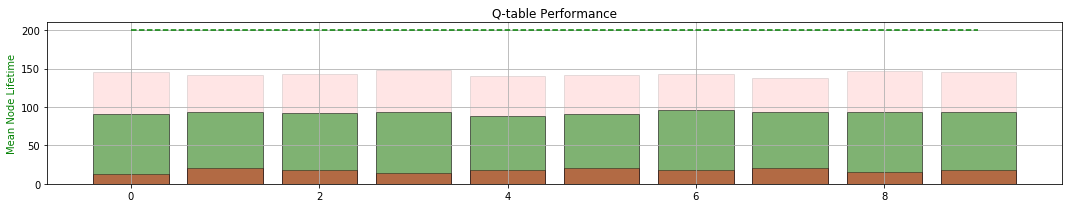

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.970	LOSS : 1.158	LOSS : 1.158	LOSS : 0.903	LOSS : 0.800	LOSS : 0.844	LOSS : 1.090	LOSS : 1.284	LOSS : 1.290	LOSS : 1.133	LOSS : 0.599	LOSS : 1.222	LOSS : 1.104	LOSS : 1.011	LOSS : 1.255	LOSS : 0.878	LOSS : 0.999	LOSS : 1.187	LOSS : 1.010	LOSS : 1.431	LOSS : 1.118	LOSS : 1.039	LOSS : 1.007	LOSS : 0.961	LOSS : 1.085	LOSS : 1.165	LOSS : 1.166	LOSS : 0.946	LOSS : 0.881	LOSS : 1.093	
Validating... MEAN TIME:  136.9
LOSS : 1.159	LOSS : 1.522	LOSS : 1.482	LOSS : 0.898	LOSS : 1.217	LOSS : 1.263	LOSS : 0.893	LOSS : 0.945	LOSS : 0.972	LOSS : 0.927	LOSS : 1.157	LOSS : 1.168	LOSS : 1.153	LOSS : 1.007	LOSS : 1.096	LOSS : 1.245	LOSS : 1.153	LOSS : 1.238	LOSS : 1.068	LOSS : 1.016	LOSS : 0.747	LOSS : 1.040	LOSS : 1.077	LOSS : 1.139	LOSS : 1.381	LOSS : 1.176	LOSS : 1.301	LOSS : 1.177	LOSS : 0.982	LOSS : 0.974	
Validating... MEAN TIME:  128.82
LOSS : 0.940	LOSS : 0.99

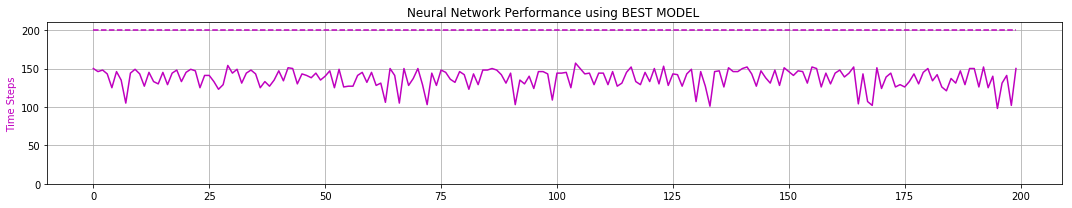

peak memory: 1481.38 MiB, increment: 1017.69 MiB
0 -max- [ 0.163  1.028  0.209  1.843]
0 -min- [-2.400 -2.658 -0.209 -2.915]

1 -max- [ 0.153  1.368  0.209  1.885]
1 -min- [-2.399 -2.661 -0.209 -3.180]

2 -max- [ 0.167  1.405  0.209  1.660]
2 -min- [-2.400 -2.484 -0.209 -3.121]

3 -max- [ 0.176  1.382  0.209  1.636]
3 -min- [-2.398 -2.646 -0.209 -3.241]

4 -max- [ 0.169  1.006  0.209  1.941]
4 -min- [-2.398 -2.866 -0.209 -2.783]

5 -max- [ 0.164  1.022  0.209  1.857]
5 -min- [-2.392 -2.656 -0.209 -2.777]

6 -max- [ 0.175  1.240  0.209  1.822]
6 -min- [-2.400 -2.641 -0.209 -3.189]

7 -max- [ 0.184  1.380  0.209  1.717]
7 -min- [-2.397 -2.481 -0.209 -3.236]

8 -max- [ 0.177  1.029  0.209  1.633]
8 -min- [-2.397 -2.464 -0.209 -2.899]

9 -max- [ 0.173  1.401  0.209  1.648]
9 -min- [-2.397 -2.484 -0.209 -3.239]

Quantization TIME:  0.01 minutes


ITERATION # 5
SMALLEST TIMESTEP in ITERATION 5: 10
REAL TIME TO GENERATE 24436 EXPERIENCES:0:00:00.751104


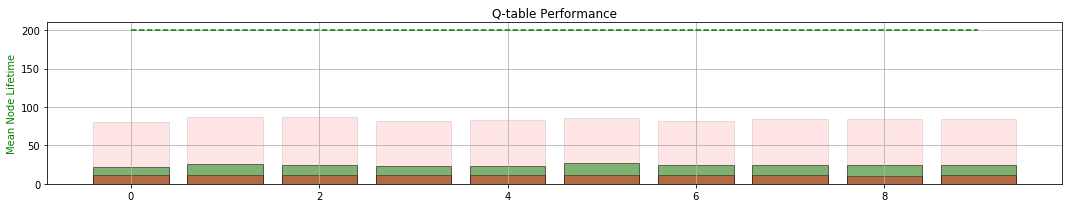

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.798	LOSS : 1.168	LOSS : 0.944	LOSS : 1.211	LOSS : 1.200	LOSS : 1.331	LOSS : 1.309	LOSS : 1.417	LOSS : 1.306	LOSS : 1.281	LOSS : 1.133	LOSS : 1.243	LOSS : 1.320	LOSS : 1.241	LOSS : 1.410	LOSS : 1.075	LOSS : 1.431	LOSS : 1.194	LOSS : 1.445	LOSS : 1.349	LOSS : 1.542	LOSS : 1.702	LOSS : 1.364	LOSS : 0.996	LOSS : 1.480	LOSS : 1.540	LOSS : 1.589	LOSS : 1.175	LOSS : 1.537	LOSS : 0.878	
Validating... MEAN TIME:  135.3
LOSS : 1.587	LOSS : 1.172	LOSS : 1.428	LOSS : 1.319	LOSS : 1.382	LOSS : 1.290	LOSS : 1.165	LOSS : 1.554	LOSS : 1.499	LOSS : 1.283	LOSS : 1.574	LOSS : 1.389	LOSS : 1.191	LOSS : 1.288	LOSS : 1.060	LOSS : 1.464	LOSS : 1.485	LOSS : 1.334	LOSS : 1.070	LOSS : 1.566	LOSS : 1.414	LOSS : 1.448	LOSS : 1.091	LOSS : 1.512	LOSS : 1.307	LOSS : 1.038	LOSS : 1.229	LOSS : 1.492	LOSS : 1.291	LOSS : 1.585	
Validating... MEAN TIME:  160.96
LOSS : 1.146	LOSS : 1.16

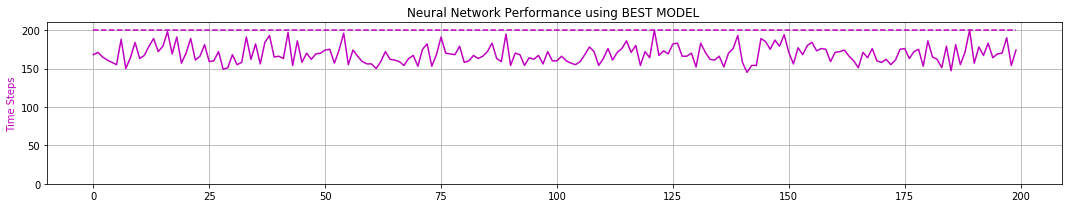

peak memory: 1481.56 MiB, increment: 1015.59 MiB
0 -max- [ 0.179  1.207  0.207  1.418]
0 -min- [-1.720 -2.475 -0.209 -1.689]

1 -max- [ 0.194  1.175  0.209  1.582]
1 -min- [-1.797 -2.802 -0.209 -1.684]

2 -max- [ 0.196  0.950  0.208  1.392]
2 -min- [-1.737 -2.753 -0.209 -1.455]

3 -max- [ 0.202  1.006  0.209  1.608]
3 -min- [-1.803 -2.942 -0.209 -1.468]

4 -max- [ 0.193  1.024  0.208  1.564]
4 -min- [-1.798 -2.954 -0.209 -1.584]

5 -max- [ 0.196  1.005  0.208  1.645]
5 -min- [-1.859 -2.950 -0.209 -1.474]

6 -max- [ 0.204  0.985  0.207  1.397]
6 -min- [-1.749 -2.780 -0.209 -1.503]

7 -max- [ 0.184  1.208  0.208  1.413]
7 -min- [-1.729 -2.805 -0.209 -1.648]

8 -max- [ 0.196  1.176  0.207  1.331]
8 -min- [-1.762 -2.764 -0.209 -1.693]

9 -max- [ 0.188  1.174  0.209  1.387]
9 -min- [-1.760 -2.787 -0.209 -1.641]

Quantization TIME:  0.01 minutes


ITERATION # 6
SMALLEST TIMESTEP in ITERATION 6: 14
REAL TIME TO GENERATE 94516 EXPERIENCES:0:00:02.190308


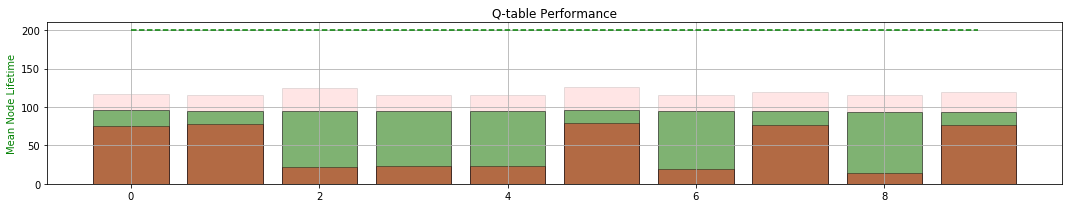

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.345	LOSS : 2.007	LOSS : 1.513	LOSS : 1.377	LOSS : 1.452	LOSS : 1.502	LOSS : 1.576	LOSS : 1.303	LOSS : 1.847	LOSS : 1.357	LOSS : 1.467	LOSS : 1.308	LOSS : 1.147	LOSS : 1.247	LOSS : 1.107	LOSS : 1.688	LOSS : 1.465	LOSS : 1.252	LOSS : 1.597	LOSS : 1.269	LOSS : 1.363	LOSS : 1.391	LOSS : 1.358	LOSS : 1.611	LOSS : 1.162	LOSS : 1.867	LOSS : 1.462	LOSS : 1.283	LOSS : 1.289	LOSS : 1.358	
Validating... MEAN TIME:  113.035
LOSS : 1.587	LOSS : 1.754	LOSS : 1.597	LOSS : 1.595	LOSS : 1.919	LOSS : 1.436	LOSS : 1.199	LOSS : 0.983	LOSS : 1.417	LOSS : 1.215	LOSS : 1.664	LOSS : 1.843	LOSS : 1.526	LOSS : 1.421	LOSS : 1.604	LOSS : 1.642	LOSS : 1.110	LOSS : 1.303	LOSS : 1.295	LOSS : 1.384	LOSS : 1.448	LOSS : 1.610	LOSS : 1.640	LOSS : 1.301	LOSS : 1.703	LOSS : 1.044	LOSS : 1.583	LOSS : 1.072	LOSS : 1.135	LOSS : 1.603	
Validating... MEAN TIME:  117.4
LOSS : 1.558	LOSS : 1.4

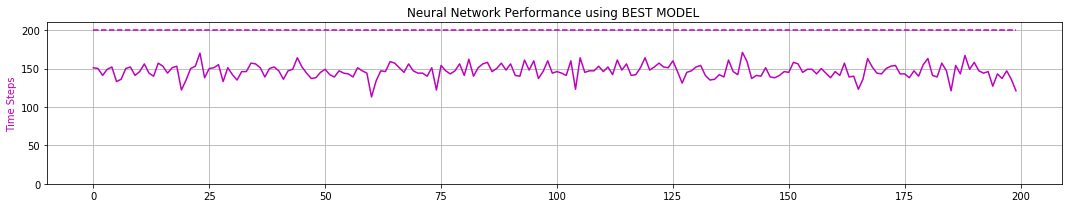

peak memory: 1423.31 MiB, increment: 1016.19 MiB
0 -max- [ 0.148  0.825  0.209  1.648]
0 -min- [-2.052 -2.630 -0.203 -1.084]

1 -max- [ 0.166  0.810  0.209  1.493]
1 -min- [-1.996 -2.617 -0.201 -1.224]

2 -max- [ 0.153  0.925  0.209  1.672]
2 -min- [-2.006 -2.662 -0.207 -1.607]

3 -max- [ 0.148  0.820  0.209  1.732]
3 -min- [-2.061 -2.657 -0.204 -1.166]

4 -max- [ 0.162  0.817  0.209  1.570]
4 -min- [-2.006 -2.640 -0.205 -1.152]

5 -max- [ 0.155  0.817  0.209  1.617]
5 -min- [-2.016 -2.848 -0.203 -2.056]

6 -max- [ 0.140  0.824  0.209  2.032]
6 -min- [-2.057 -3.141 -0.206 -1.251]

7 -max- [ 0.167  0.798  0.209  1.419]
7 -min- [-2.032 -2.621 -0.200 -1.237]

8 -max- [ 0.150  0.636  0.209  1.514]
8 -min- [-2.048 -2.656 -0.208 -1.794]

9 -max- [ 0.168  0.829  0.209  1.670]
9 -min- [-2.059 -2.588 -0.204 -1.257]

Quantization TIME:  0.02 minutes


ITERATION # 7
SMALLEST TIMESTEP in ITERATION 7: 11
REAL TIME TO GENERATE 94736 EXPERIENCES:0:00:02.303010


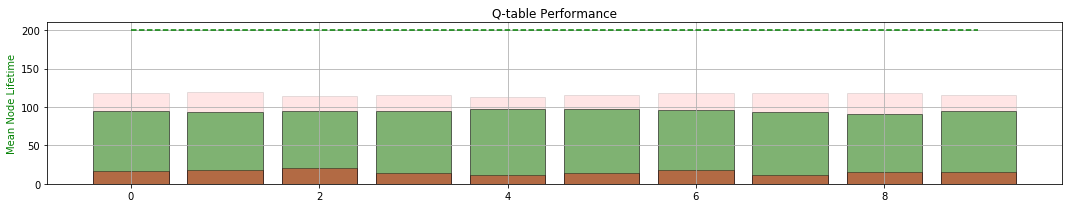

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.339	LOSS : 1.234	LOSS : 1.442	LOSS : 1.737	LOSS : 1.654	LOSS : 1.501	LOSS : 1.505	LOSS : 1.611	LOSS : 1.358	LOSS : 1.531	LOSS : 1.337	LOSS : 1.536	LOSS : 1.648	LOSS : 1.420	LOSS : 1.220	LOSS : 1.460	LOSS : 1.755	LOSS : 1.305	LOSS : 1.351	LOSS : 1.533	LOSS : 1.777	LOSS : 1.582	LOSS : 1.563	LOSS : 1.778	LOSS : 1.733	LOSS : 1.350	LOSS : 1.963	LOSS : 1.567	LOSS : 1.854	LOSS : 1.376	
Validating... MEAN TIME:  115.615
LOSS : 1.349	LOSS : 1.308	LOSS : 1.610	LOSS : 1.671	LOSS : 1.633	LOSS : 1.715	LOSS : 1.701	LOSS : 1.650	LOSS : 1.761	LOSS : 1.528	LOSS : 1.711	LOSS : 1.787	LOSS : 1.686	LOSS : 1.124	LOSS : 1.387	LOSS : 1.355	LOSS : 1.228	LOSS : 1.121	LOSS : 1.657	LOSS : 1.454	LOSS : 1.177	LOSS : 1.772	LOSS : 1.477	LOSS : 1.373	LOSS : 1.662	LOSS : 1.465	LOSS : 1.415	LOSS : 1.162	LOSS : 1.913	LOSS : 1.391	
Validating... MEAN TIME:  118.36
LOSS : 1.668	LOSS : 1.

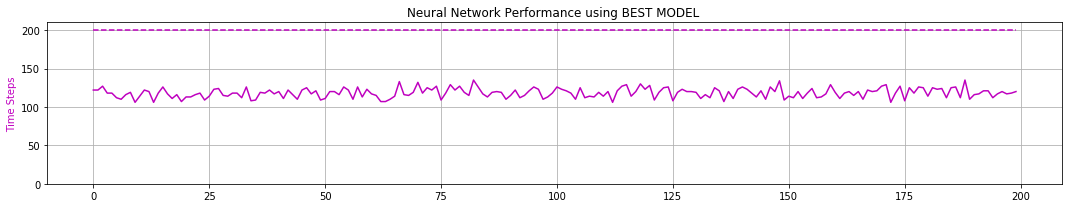

peak memory: 1469.77 MiB, increment: 1054.73 MiB
0 -max- [ 0.191  0.827  0.209  1.415]
0 -min- [-2.399 -3.019 -0.209 -1.187]

1 -max- [ 0.161  0.830  0.209  1.398]
1 -min- [-2.396 -2.953 -0.209 -1.283]

2 -max- [ 0.168  0.806  0.209  1.702]
2 -min- [-2.400 -3.168 -0.209 -1.261]

3 -max- [ 0.175  0.807  0.209  1.410]
3 -min- [-2.398 -2.933 -0.209 -1.099]

4 -max- [ 0.170  0.827  0.209  1.411]
4 -min- [-2.397 -2.941 -0.205 -1.351]

5 -max- [ 0.155  0.972  0.209  1.439]
5 -min- [-2.397 -2.952 -0.209 -1.344]

6 -max- [ 0.173  0.767  0.209  1.394]
6 -min- [-2.399 -2.950 -0.206 -1.164]

7 -max- [ 0.166  0.832  0.209  1.678]
7 -min- [-2.398 -3.201 -0.209 -1.410]

8 -max- [ 0.182  0.802  0.209  1.692]
8 -min- [-2.395 -2.997 -0.209 -1.341]

9 -max- [ 0.169  0.807  0.209  1.624]
9 -min- [-2.399 -2.945 -0.207 -1.281]

Quantization TIME:  0.01 minutes


ITERATION # 8
SMALLEST TIMESTEP in ITERATION 8: 11
REAL TIME TO GENERATE 89625 EXPERIENCES:0:00:02.226417


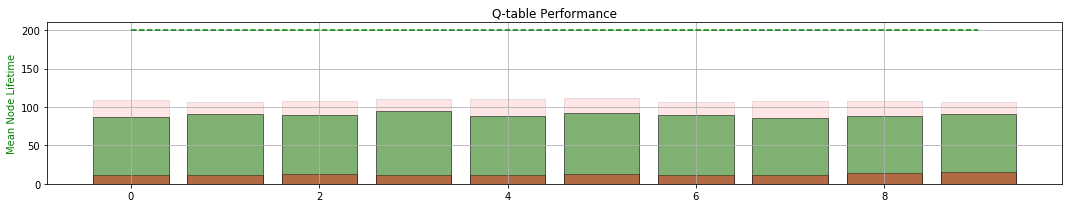

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.090	LOSS : 1.530	LOSS : 0.941	LOSS : 1.405	LOSS : 1.248	LOSS : 1.500	LOSS : 1.442	LOSS : 1.639	LOSS : 1.723	LOSS : 1.621	LOSS : 1.501	LOSS : 1.565	LOSS : 1.266	LOSS : 1.833	LOSS : 1.642	LOSS : 1.782	LOSS : 1.227	LOSS : 1.446	LOSS : 2.107	LOSS : 1.342	LOSS : 1.370	LOSS : 1.334	LOSS : 1.256	LOSS : 1.883	LOSS : 1.307	LOSS : 1.765	LOSS : 1.248	LOSS : 1.055	LOSS : 1.162	LOSS : 1.444	
Validating... MEAN TIME:  106.555
LOSS : 1.450	LOSS : 1.679	LOSS : 1.275	LOSS : 1.356	LOSS : 1.345	LOSS : 1.631	LOSS : 1.264	LOSS : 1.440	LOSS : 1.545	LOSS : 1.621	LOSS : 1.185	LOSS : 1.429	LOSS : 1.391	LOSS : 1.470	LOSS : 1.377	LOSS : 1.801	LOSS : 1.329	LOSS : 1.537	LOSS : 1.722	LOSS : 1.503	LOSS : 1.068	LOSS : 1.462	LOSS : 1.581	LOSS : 1.218	LOSS : 1.339	LOSS : 1.425	LOSS : 1.176	LOSS : 1.401	LOSS : 1.511	LOSS : 1.525	
Validating... MEAN TIME:  109.36
LOSS : 1.223	LOSS : 1.

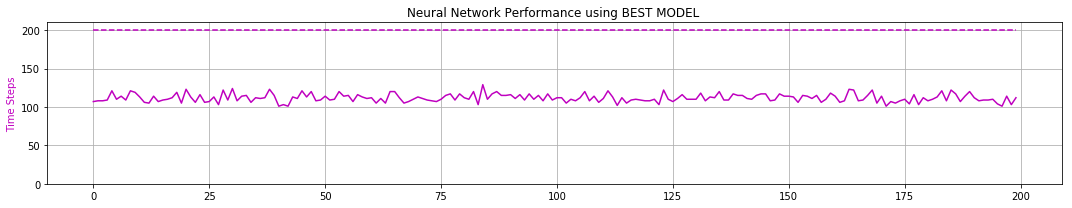

peak memory: 1441.11 MiB, increment: 1055.43 MiB
0 -max- [ 0.190  0.972  0.130  1.645]
0 -min- [-2.400 -3.524 -0.209 -1.364]

1 -max- [ 0.180  0.944  0.136  1.391]
1 -min- [-2.400 -3.200 -0.209 -1.547]

2 -max- [ 0.191  0.967  0.126  1.628]
2 -min- [-2.400 -3.356 -0.209 -1.349]

3 -max- [ 0.180  0.826  0.127  1.387]
3 -min- [-2.400 -3.192 -0.208 -1.174]

4 -max- [ 0.174  1.013  0.142  1.672]
4 -min- [-2.399 -3.536 -0.209 -1.381]

5 -max- [ 0.194  0.801  0.125  1.394]
5 -min- [-2.400 -3.184 -0.209 -1.227]

6 -max- [ 0.169  0.833  0.149  1.396]
6 -min- [-2.400 -3.285 -0.209 -1.312]

7 -max- [ 0.198  0.991  0.113  1.388]
7 -min- [-2.399 -3.185 -0.209 -1.373]

8 -max- [ 0.188  0.828  0.130  1.383]
8 -min- [-2.398 -3.200 -0.209 -1.305]

9 -max- [ 0.176  0.820  0.145  1.386]
9 -min- [-2.400 -3.370 -0.209 -1.276]

Quantization TIME:  0.02 minutes


ITERATION # 9
SMALLEST TIMESTEP in ITERATION 9: 11
REAL TIME TO GENERATE 74376 EXPERIENCES:0:00:01.737292


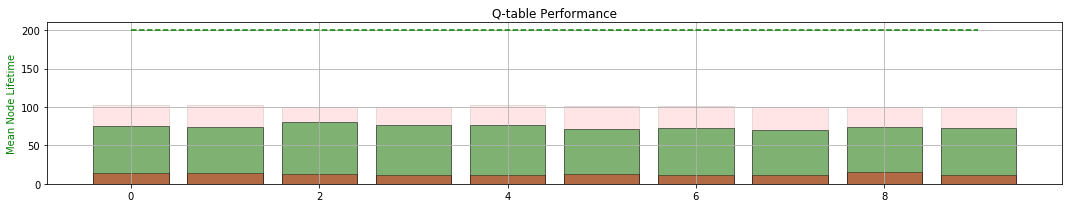

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.382	LOSS : 1.261	LOSS : 1.248	LOSS : 1.410	LOSS : 1.370	LOSS : 1.221	LOSS : 1.504	LOSS : 1.302	LOSS : 1.179	LOSS : 1.172	LOSS : 1.104	LOSS : 0.904	LOSS : 1.502	LOSS : 1.095	LOSS : 1.503	LOSS : 1.134	LOSS : 1.190	LOSS : 1.377	LOSS : 1.178	LOSS : 1.216	LOSS : 1.134	LOSS : 1.022	LOSS : 1.150	LOSS : 1.095	LOSS : 1.129	LOSS : 1.325	LOSS : 1.123	LOSS : 1.316	LOSS : 1.427	LOSS : 1.439	
Validating... MEAN TIME:  110.37
LOSS : 1.490	LOSS : 1.282	LOSS : 1.435	LOSS : 1.334	LOSS : 1.157	LOSS : 0.946	LOSS : 1.176	LOSS : 1.175	LOSS : 1.244	LOSS : 1.089	LOSS : 1.695	LOSS : 1.260	LOSS : 1.352	LOSS : 1.307	LOSS : 1.265	LOSS : 1.063	LOSS : 1.302	LOSS : 1.499	LOSS : 1.095	LOSS : 1.259	LOSS : 1.461	LOSS : 1.174	LOSS : 1.021	LOSS : 1.067	LOSS : 1.323	LOSS : 1.054	LOSS : 1.038	LOSS : 1.341	LOSS : 1.300	LOSS : 1.608	
Validating... MEAN TIME:  108.325
LOSS : 0.911	LOSS : 0.

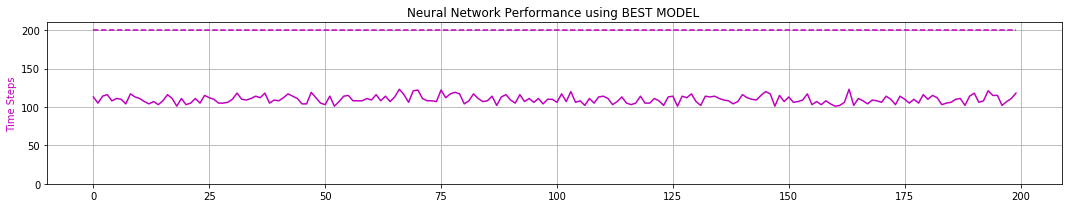

peak memory: 1459.16 MiB, increment: 1014.89 MiB
0 -max- [ 0.185  1.017  0.049  0.860]
0 -min- [-2.292 -2.754 -0.209 -1.485]

1 -max- [ 0.205  0.967  0.050  0.683]
1 -min- [-2.166 -2.742 -0.209 -1.349]

2 -max- [ 0.194  0.989  0.046  0.806]
2 -min- [-2.274 -2.714 -0.209 -1.379]

3 -max- [ 0.182  1.013  0.051  0.684]
3 -min- [-2.066 -2.592 -0.209 -1.457]

4 -max- [ 0.202  0.980  0.046  0.875]
4 -min- [-2.206 -2.733 -0.209 -1.397]

5 -max- [ 0.180  0.831  0.048  0.874]
5 -min- [-2.382 -2.950 -0.209 -1.216]

6 -max- [ 0.195  0.997  0.050  0.824]
6 -min- [-2.211 -2.689 -0.209 -1.406]

7 -max- [ 0.196  1.024  0.050  0.681]
7 -min- [-2.218 -2.686 -0.209 -1.393]

8 -max- [ 0.186  0.829  0.049  0.898]
8 -min- [-2.266 -2.736 -0.209 -1.381]

9 -max- [ 0.202  0.824  0.047  0.694]
9 -min- [-2.265 -2.749 -0.209 -1.332]

Quantization TIME:  0.02 minutes


ITERATION # 10
SMALLEST TIMESTEP in ITERATION 10: 11
REAL TIME TO GENERATE 76324 EXPERIENCES:0:00:01.897184


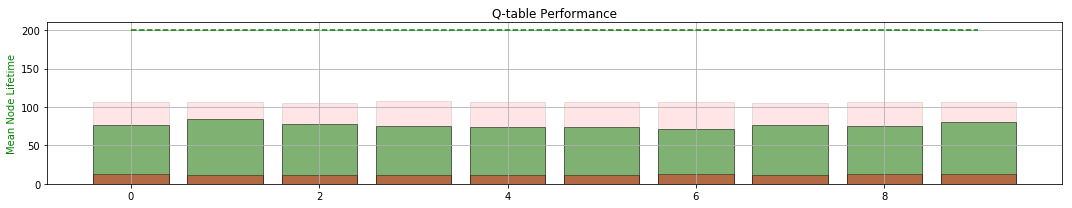

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.254	LOSS : 1.731	LOSS : 1.283	LOSS : 1.344	LOSS : 1.207	LOSS : 1.449	LOSS : 1.484	LOSS : 1.509	LOSS : 1.108	LOSS : 1.371	LOSS : 1.236	LOSS : 1.474	LOSS : 1.155	LOSS : 1.418	LOSS : 1.331	LOSS : 1.039	LOSS : 1.431	LOSS : 1.670	LOSS : 1.549	LOSS : 1.108	LOSS : 1.091	LOSS : 1.243	LOSS : 1.089	LOSS : 1.200	LOSS : 1.529	LOSS : 1.359	LOSS : 1.177	LOSS : 1.214	LOSS : 1.257	LOSS : 1.465	
Validating... MEAN TIME:  99.4
LOSS : 1.390	LOSS : 1.188	LOSS : 1.323	LOSS : 1.224	LOSS : 1.422	LOSS : 0.983	LOSS : 1.659	LOSS : 1.542	LOSS : 1.201	LOSS : 1.334	LOSS : 1.048	LOSS : 1.300	LOSS : 1.100	LOSS : 1.384	LOSS : 1.584	LOSS : 1.276	LOSS : 1.310	LOSS : 1.243	LOSS : 1.319	LOSS : 1.279	LOSS : 1.065	LOSS : 1.381	LOSS : 0.991	LOSS : 1.560	LOSS : 1.261	LOSS : 1.502	LOSS : 1.567	LOSS : 1.581	LOSS : 1.762	LOSS : 1.542	
Validating... MEAN TIME:  99.38
LOSS : 1.487	LOSS : 1.495	

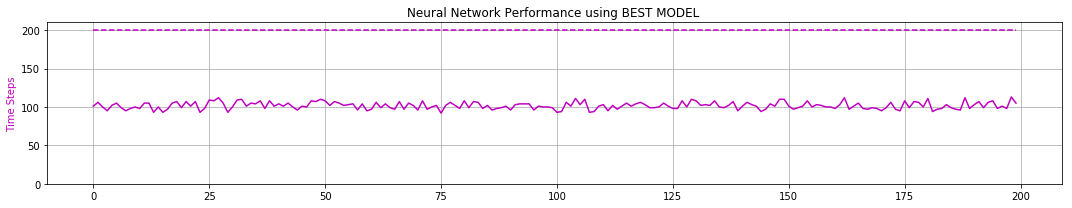

peak memory: 1400.30 MiB, increment: 1023.92 MiB
0 -max- [ 0.199  0.967  0.050  0.733]
0 -min- [-2.398 -3.144 -0.209 -1.350]

1 -max- [ 0.188  0.828  0.051  0.903]
1 -min- [-2.398 -3.150 -0.209 -1.244]

2 -max- [ 0.182  1.013  0.051  0.790]
2 -min- [-2.400 -3.114 -0.209 -1.361]

3 -max- [ 0.202  0.980  0.046  0.849]
3 -min- [-2.398 -3.157 -0.209 -1.529]

4 -max- [ 0.191  0.984  0.048  0.889]
4 -min- [-2.400 -3.151 -0.209 -1.398]

5 -max- [ 0.195  0.997  0.050  0.744]
5 -min- [-2.399 -3.104 -0.209 -1.373]

6 -max- [ 0.196  0.976  0.052  0.822]
6 -min- [-2.398 -3.140 -0.209 -1.437]

7 -max- [ 0.189  1.023  0.049  0.815]
7 -min- [-2.400 -3.152 -0.209 -1.440]

8 -max- [ 0.202  1.003  0.047  0.832]
8 -min- [-2.397 -3.155 -0.209 -1.429]

9 -max- [ 0.192  1.021  0.049  0.698]
9 -min- [-2.400 -3.147 -0.209 -1.451]

Quantization TIME:  0.02 minutes


ITERATION # 11
SMALLEST TIMESTEP in ITERATION 11: 11
REAL TIME TO GENERATE 42503 EXPERIENCES:0:00:01.136081


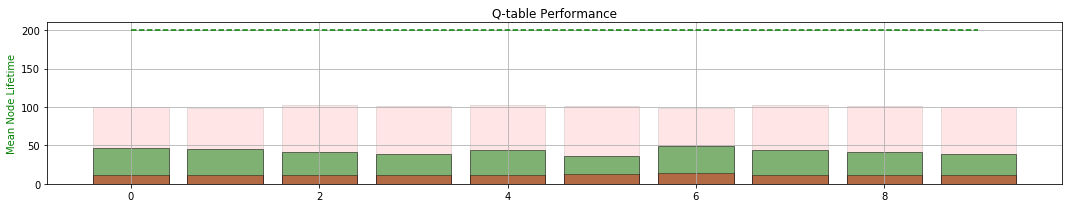

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.422	LOSS : 1.791	LOSS : 1.834	LOSS : 1.456	LOSS : 1.356	LOSS : 1.339	LOSS : 1.313	LOSS : 1.572	LOSS : 2.029	LOSS : 1.272	LOSS : 1.506	LOSS : 1.481	LOSS : 1.476	LOSS : 1.771	LOSS : 1.640	LOSS : 1.701	LOSS : 1.323	LOSS : 1.367	LOSS : 1.657	LOSS : 1.456	LOSS : 1.309	LOSS : 1.691	LOSS : 1.682	LOSS : 1.229	LOSS : 2.010	LOSS : 1.733	LOSS : 1.360	LOSS : 1.259	LOSS : 1.427	LOSS : 1.451	
Validating... MEAN TIME:  101.08
LOSS : 1.730	LOSS : 1.573	LOSS : 1.431	LOSS : 1.175	LOSS : 1.692	LOSS : 1.510	LOSS : 1.393	LOSS : 1.260	LOSS : 1.674	LOSS : 1.448	LOSS : 1.418	LOSS : 1.703	LOSS : 1.330	LOSS : 1.469	LOSS : 1.261	LOSS : 1.493	LOSS : 1.537	LOSS : 1.324	LOSS : 1.543	LOSS : 1.843	LOSS : 1.636	LOSS : 1.522	LOSS : 1.824	LOSS : 1.239	LOSS : 1.576	LOSS : 1.286	LOSS : 1.580	LOSS : 1.396	LOSS : 1.567	LOSS : 1.319	
Validating... MEAN TIME:  100.85
LOSS : 1.348	LOSS : 1.6

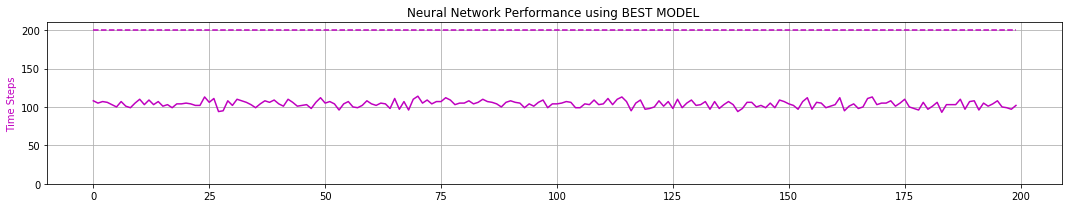

peak memory: 1461.96 MiB, increment: 1036.62 MiB
0 -max- [ 0.188  1.024  0.046  0.917]
0 -min- [-2.399 -3.449 -0.209 -1.449]

1 -max- [ 0.182  1.013  0.051  0.979]
1 -min- [-2.400 -3.341 -0.209 -1.361]

2 -max- [ 0.202  0.979  0.046  0.706]
2 -min- [-2.396 -3.170 -0.209 -1.364]

3 -max- [ 0.174  0.835  0.048  0.739]
3 -min- [-2.396 -3.165 -0.209 -1.365]

4 -max- [ 0.200  0.991  0.050  0.838]
4 -min- [-2.399 -3.302 -0.209 -1.440]

5 -max- [ 0.196  0.829  0.050  0.927]
5 -min- [-2.400 -3.453 -0.209 -1.372]

6 -max- [ 0.189  0.960  0.049  0.919]
6 -min- [-2.400 -3.467 -0.209 -1.452]

7 -max- [ 0.202  0.980  0.053  0.930]
7 -min- [-2.400 -3.362 -0.209 -1.421]

8 -max- [ 0.192  0.984  0.049  0.954]
8 -min- [-2.399 -3.328 -0.209 -1.456]

9 -max- [ 0.168  0.979  0.050  0.871]
9 -min- [-2.398 -3.450 -0.209 -1.426]

Quantization TIME:  0.01 minutes


ITERATION # 12
SMALLEST TIMESTEP in ITERATION 12: 12
REAL TIME TO GENERATE 75953 EXPERIENCES:0:00:01.851410


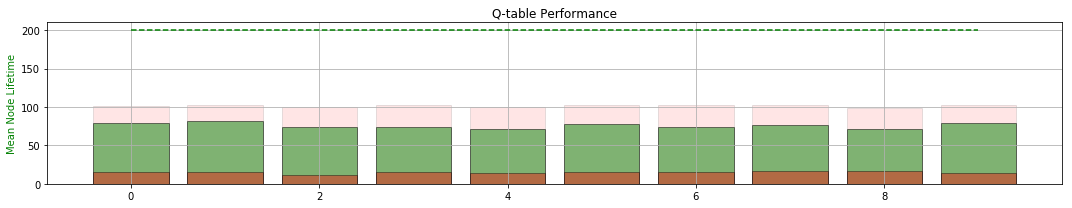

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.774	LOSS : 1.607	LOSS : 1.426	LOSS : 1.499	LOSS : 1.806	LOSS : 1.210	LOSS : 1.194	LOSS : 1.805	LOSS : 1.667	LOSS : 1.482	LOSS : 1.528	LOSS : 1.665	LOSS : 1.595	LOSS : 1.683	LOSS : 1.814	LOSS : 1.452	LOSS : 1.862	LOSS : 1.603	LOSS : 1.702	LOSS : 1.826	LOSS : 1.518	LOSS : 1.717	LOSS : 1.563	LOSS : 1.628	LOSS : 1.707	LOSS : 2.002	LOSS : 1.871	LOSS : 1.287	LOSS : 1.512	LOSS : 1.548	
Validating... MEAN TIME:  100.975
LOSS : 1.883	LOSS : 1.555	LOSS : 1.597	LOSS : 1.564	LOSS : 1.468	LOSS : 1.931	LOSS : 1.619	LOSS : 1.727	LOSS : 1.911	LOSS : 1.420	LOSS : 1.593	LOSS : 1.926	LOSS : 1.629	LOSS : 1.400	LOSS : 1.479	LOSS : 1.672	LOSS : 1.466	LOSS : 1.184	LOSS : 1.746	LOSS : 1.569	LOSS : 1.609	LOSS : 2.378	LOSS : 1.789	LOSS : 1.499	LOSS : 2.045	LOSS : 1.565	LOSS : 1.769	LOSS : 1.736	LOSS : 1.745	LOSS : 1.826	
Validating... MEAN TIME:  100.595
LOSS : 1.465	LOSS : 1

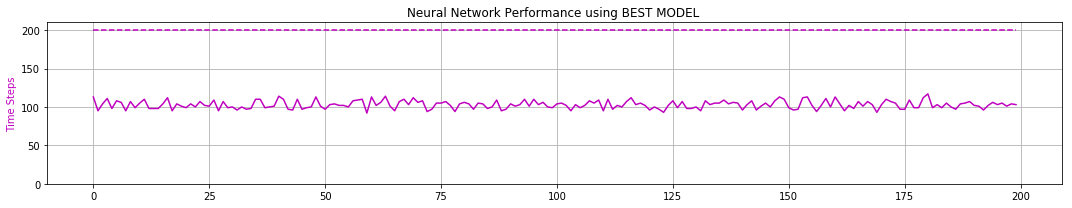

peak memory: 1443.18 MiB, increment: 1016.95 MiB
0 -max- [ 0.174  1.013  0.051  1.003]
0 -min- [-2.399 -3.678 -0.209 -1.361]

1 -max- [ 0.202  0.979  0.046  0.962]
1 -min- [-2.399 -3.525 -0.209 -1.364]

2 -max- [ 0.188  0.813  0.048  0.951]
2 -min- [-2.396 -3.544 -0.209 -1.341]

3 -max- [ 0.195  0.997  0.050  1.002]
3 -min- [-2.399 -3.680 -0.209 -1.362]

4 -max- [ 0.196  1.009  0.050  1.010]
4 -min- [-2.396 -3.654 -0.209 -1.400]

5 -max- [ 0.175  0.826  0.049  1.038]
5 -min- [-2.400 -3.666 -0.209 -1.268]

6 -max- [ 0.202  0.982  0.047  0.994]
6 -min- [-2.398 -3.656 -0.209 -1.361]

7 -max- [ 0.198  0.827  0.049  0.958]
7 -min- [-2.399 -3.546 -0.209 -1.269]

8 -max- [ 0.161  0.826  0.050  1.005]
8 -min- [-2.393 -3.667 -0.209 -1.229]

9 -max- [ 0.184  0.927  0.050  0.991]
9 -min- [-2.397 -3.635 -0.209 -1.358]

Quantization TIME:  0.02 minutes


ITERATION # 13
SMALLEST TIMESTEP in ITERATION 13: 11
REAL TIME TO GENERATE 55336 EXPERIENCES:0:00:01.357950


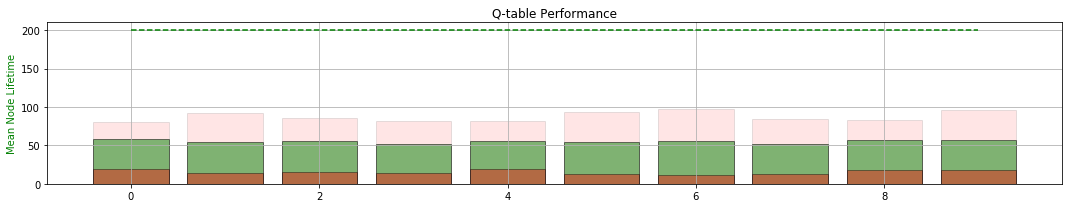

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.324	LOSS : 1.501	LOSS : 1.917	LOSS : 1.865	LOSS : 1.879	LOSS : 1.531	LOSS : 1.601	LOSS : 2.553	LOSS : 1.438	LOSS : 1.831	LOSS : 1.581	LOSS : 1.647	LOSS : 1.676	LOSS : 1.586	LOSS : 1.630	LOSS : 1.815	LOSS : 1.882	LOSS : 1.643	LOSS : 1.382	LOSS : 1.751	LOSS : 1.790	LOSS : 1.591	LOSS : 1.751	LOSS : 1.732	LOSS : 1.659	LOSS : 1.864	LOSS : 1.267	LOSS : 1.813	LOSS : 1.751	LOSS : 1.661	
Validating... MEAN TIME:  103.32
LOSS : 1.969	LOSS : 1.692	LOSS : 1.885	LOSS : 1.927	LOSS : 1.735	LOSS : 1.847	LOSS : 2.209	LOSS : 1.747	LOSS : 1.995	LOSS : 2.288	LOSS : 1.924	LOSS : 1.318	LOSS : 1.602	LOSS : 1.432	LOSS : 1.818	LOSS : 1.866	LOSS : 1.961	LOSS : 1.427	LOSS : 1.851	LOSS : 1.487	LOSS : 1.627	LOSS : 1.818	LOSS : 1.638	LOSS : 1.510	LOSS : 1.787	LOSS : 1.680	LOSS : 1.886	LOSS : 1.444	LOSS : 1.866	LOSS : 1.631	
Validating... MEAN TIME:  104.98
LOSS : 1.995	LOSS : 1.4

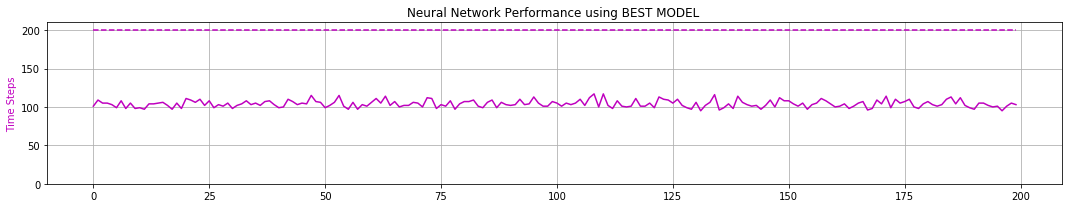

peak memory: 1414.64 MiB, increment: 1016.82 MiB
0 -max- [ 0.194  0.979  0.046  0.638]
0 -min- [-1.515 -2.594 -0.209 -1.364]

1 -max- [ 0.172  0.829  0.048  0.539]
1 -min- [-2.215 -2.938 -0.209 -1.264]

2 -max- [ 0.198  0.991  0.050  0.605]
2 -min- [-1.750 -2.778 -0.209 -1.362]

3 -max- [ 0.188  0.828  0.050  0.637]
3 -min- [-1.727 -2.755 -0.209 -1.369]

4 -max- [ 0.170  0.826  0.049  0.681]
4 -min- [-1.574 -2.610 -0.209 -1.238]

5 -max- [ 0.194  0.982  0.054  0.656]
5 -min- [-2.359 -3.293 -0.209 -1.361]

6 -max- [ 0.184  0.964  0.049  0.767]
6 -min- [-2.339 -3.335 -0.209 -1.371]

7 -max- [ 0.168  0.826  0.050  0.794]
7 -min- [-1.482 -2.603 -0.209 -1.371]

8 -max- [ 0.171  0.989  0.050  0.593]
8 -min- [-1.497 -2.599 -0.209 -1.453]

9 -max- [ 0.172  0.966  0.050  0.649]
9 -min- [-2.253 -2.941 -0.209 -1.364]

Quantization TIME:  0.02 minutes


ITERATION # 14
SMALLEST TIMESTEP in ITERATION 14: 12
REAL TIME TO GENERATE 58741 EXPERIENCES:0:00:01.537344


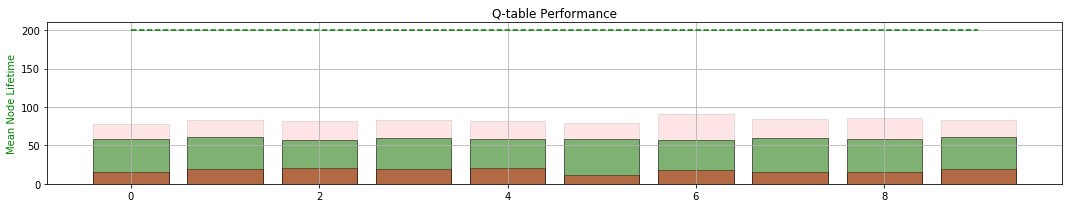

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.314	LOSS : 1.791	LOSS : 1.511	LOSS : 1.879	LOSS : 1.461	LOSS : 1.681	LOSS : 1.930	LOSS : 1.595	LOSS : 1.361	LOSS : 1.682	LOSS : 1.818	LOSS : 1.835	LOSS : 1.667	LOSS : 1.488	LOSS : 1.782	LOSS : 1.621	LOSS : 1.668	LOSS : 1.747	LOSS : 1.460	LOSS : 2.336	LOSS : 1.685	LOSS : 1.910	LOSS : 1.808	LOSS : 1.547	LOSS : 1.456	LOSS : 1.807	LOSS : 2.035	LOSS : 1.646	LOSS : 1.725	LOSS : 1.657	
Validating... MEAN TIME:  110.125
LOSS : 1.601	LOSS : 1.978	LOSS : 1.765	LOSS : 1.768	LOSS : 1.906	LOSS : 1.316	LOSS : 1.454	LOSS : 2.093	LOSS : 1.730	LOSS : 1.650	LOSS : 1.408	LOSS : 2.080	LOSS : 1.893	LOSS : 1.933	LOSS : 1.955	LOSS : 2.135	LOSS : 2.090	LOSS : 1.604	LOSS : 1.714	LOSS : 1.906	LOSS : 1.734	LOSS : 1.883	LOSS : 1.957	LOSS : 1.565	LOSS : 1.793	LOSS : 1.231	LOSS : 1.528	LOSS : 1.732	LOSS : 1.891	LOSS : 1.696	
Validating... MEAN TIME:  109.915
LOSS : 1.600	LOSS : 1

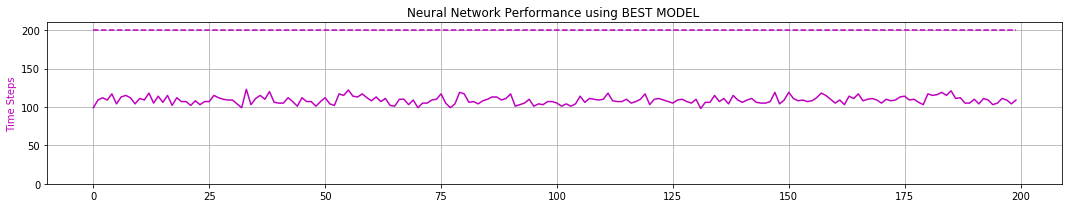

peak memory: 1419.96 MiB, increment: 994.65 MiB
0 -max- [ 0.177  0.936  0.053  0.822]
0 -min- [-1.527 -2.570 -0.209 -1.347]

1 -max- [ 0.198  1.013  0.050  0.605]
1 -min- [-1.473 -2.528 -0.209 -1.406]

2 -max- [ 0.188  0.828  0.050  0.602]
2 -min- [-1.606 -2.758 -0.209 -1.250]

3 -max- [ 0.172  0.826  0.049  0.599]
3 -min- [-1.640 -2.751 -0.209 -1.200]

4 -max- [ 0.201  0.982  0.047  0.628]
4 -min- [-1.570 -2.609 -0.209 -1.361]

5 -max- [ 0.176  0.978  0.049  0.613]
5 -min- [-1.457 -2.563 -0.209 -1.448]

6 -max- [ 0.158  0.931  0.050  0.608]
6 -min- [-1.891 -2.890 -0.209 -1.331]

7 -max- [ 0.177  0.927  0.050  0.661]
7 -min- [-1.691 -2.746 -0.209 -1.358]

8 -max- [ 0.163  0.996  0.050  0.668]
8 -min- [-1.779 -2.780 -0.209 -1.410]

9 -max- [ 0.186  1.021  0.049  0.842]
9 -min- [-1.597 -2.691 -0.209 -1.402]

Quantization TIME:  0.01 minutes


ITERATION # 15
SMALLEST TIMESTEP in ITERATION 15: 14
REAL TIME TO GENERATE 70147 EXPERIENCES:0:00:01.804497


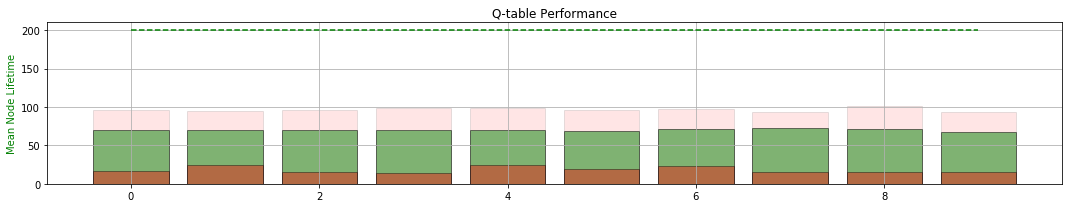

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.026	LOSS : 1.972	LOSS : 1.612	LOSS : 2.033	LOSS : 1.527	LOSS : 1.731	LOSS : 2.024	LOSS : 1.804	LOSS : 1.558	LOSS : 1.485	LOSS : 1.453	LOSS : 1.530	LOSS : 1.753	LOSS : 2.009	LOSS : 2.034	LOSS : 1.840	LOSS : 1.673	LOSS : 1.673	LOSS : 1.995	LOSS : 1.535	LOSS : 1.596	LOSS : 1.697	LOSS : 1.343	LOSS : 2.007	LOSS : 1.745	LOSS : 1.794	LOSS : 1.788	LOSS : 1.633	LOSS : 1.725	LOSS : 1.607	
Validating... MEAN TIME:  105.215
LOSS : 1.891	LOSS : 1.838	LOSS : 1.786	LOSS : 1.749	LOSS : 1.784	LOSS : 1.612	LOSS : 2.025	LOSS : 1.395	LOSS : 1.575	LOSS : 1.820	LOSS : 1.793	LOSS : 1.861	LOSS : 1.554	LOSS : 1.647	LOSS : 1.580	LOSS : 1.906	LOSS : 1.972	LOSS : 1.995	LOSS : 1.649	LOSS : 1.526	LOSS : 1.554	LOSS : 1.704	LOSS : 1.518	LOSS : 1.957	LOSS : 1.792	LOSS : 1.938	LOSS : 2.018	LOSS : 2.126	LOSS : 1.322	LOSS : 1.831	
Validating... MEAN TIME:  103.22
LOSS : 1.348	LOSS : 1.

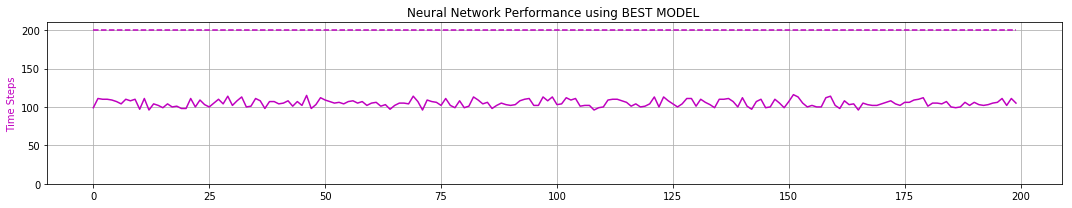

peak memory: 1406.98 MiB, increment: 1016.58 MiB
0 -max- [ 0.198  0.991  0.050  0.746]
0 -min- [-2.293 -2.927 -0.209 -1.362]

1 -max- [ 0.188  0.828  0.050  0.562]
1 -min- [-2.032 -2.901 -0.209 -1.223]

2 -max- [ 0.170  0.826  0.049  0.736]
2 -min- [-2.256 -2.929 -0.209 -1.281]

3 -max- [ 0.194  0.982  0.054  0.604]
3 -min- [-2.023 -2.894 -0.209 -1.361]

4 -max- [ 0.185  1.012  0.049  0.622]
4 -min- [-2.230 -2.905 -0.209 -1.459]

5 -max- [ 0.166  0.829  0.050  0.595]
5 -min- [-2.079 -2.913 -0.209 -1.240]

6 -max- [ 0.171  0.927  0.050  0.578]
6 -min- [-2.130 -2.896 -0.209 -1.358]

7 -max- [ 0.160  0.966  0.050  0.611]
7 -min- [-2.220 -2.882 -0.209 -1.364]

8 -max- [ 0.194  0.968  0.049  0.606]
8 -min- [-2.272 -2.907 -0.209 -1.407]

9 -max- [ 0.186  0.831  0.049  0.611]
9 -min- [-2.007 -2.789 -0.209 -1.342]

Quantization TIME:  0.01 minutes


ITERATION # 16
SMALLEST TIMESTEP in ITERATION 16: 11
REAL TIME TO GENERATE 30635 EXPERIENCES:0:00:00.783142


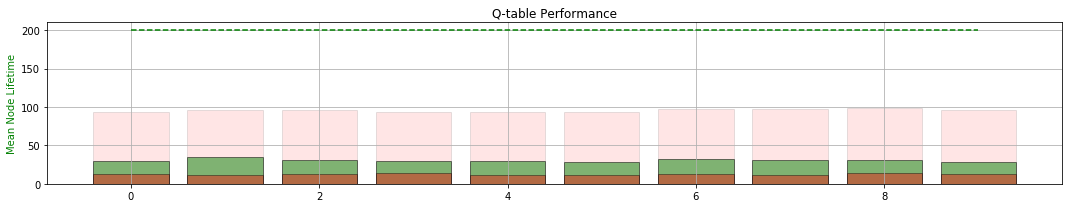

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.801	LOSS : 2.275	LOSS : 1.801	LOSS : 1.993	LOSS : 2.057	LOSS : 2.039	LOSS : 2.002	LOSS : 1.711	LOSS : 1.786	LOSS : 1.850	LOSS : 1.976	LOSS : 2.011	LOSS : 1.877	LOSS : 2.183	LOSS : 1.878	LOSS : 1.775	LOSS : 1.910	LOSS : 1.648	LOSS : 1.830	LOSS : 1.882	LOSS : 2.100	LOSS : 1.345	LOSS : 1.713	LOSS : 1.871	LOSS : 2.132	LOSS : 1.571	LOSS : 2.240	LOSS : 1.808	LOSS : 1.862	LOSS : 1.605	
Validating... MEAN TIME:  102.835
LOSS : 1.751	LOSS : 1.721	LOSS : 1.887	LOSS : 1.955	LOSS : 2.116	LOSS : 1.941	LOSS : 2.421	LOSS : 2.006	LOSS : 1.607	LOSS : 1.423	LOSS : 2.109	LOSS : 1.557	LOSS : 2.196	LOSS : 1.963	LOSS : 1.857	LOSS : 2.557	LOSS : 1.886	LOSS : 1.404	LOSS : 1.919	LOSS : 1.833	LOSS : 1.978	LOSS : 2.047	LOSS : 2.057	LOSS : 1.771	LOSS : 2.003	LOSS : 1.782	LOSS : 2.009	LOSS : 1.347	LOSS : 1.833	LOSS : 1.821	
Validating... MEAN TIME:  102.83
LOSS : 1.608	LOSS : 2.

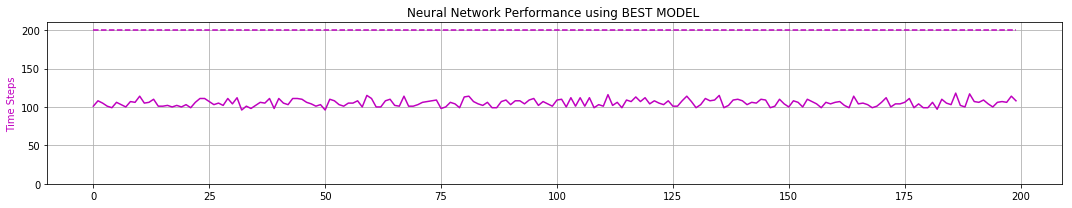

peak memory: 1421.02 MiB, increment: 1035.86 MiB
0 -max- [ 0.199  1.023  0.050  0.645]
0 -min- [-2.399 -2.967 -0.209 -1.433]

1 -max- [ 0.187  0.956  0.049  0.609]
1 -min- [-2.398 -3.116 -0.209 -1.458]

2 -max- [ 0.204  0.983  0.047  0.601]
2 -min- [-2.391 -2.969 -0.209 -1.375]

3 -max- [ 0.200  0.965  0.053  0.597]
3 -min- [-2.227 -2.965 -0.209 -1.436]

4 -max- [ 0.171  1.005  0.050  0.608]
4 -min- [-2.342 -3.107 -0.209 -1.440]

5 -max- [ 0.195  0.927  0.050  0.516]
5 -min- [-2.350 -3.078 -0.209 -1.411]

6 -max- [ 0.191  0.967  0.050  0.578]
6 -min- [-2.388 -3.061 -0.209 -1.410]

7 -max- [ 0.200  0.991  0.049  0.579]
7 -min- [-2.366 -3.131 -0.209 -1.419]

8 -max- [ 0.198  1.025  0.049  0.719]
8 -min- [-2.397 -2.973 -0.209 -1.468]

9 -max- [ 0.200  0.946  0.050  0.749]
9 -min- [-2.099 -2.891 -0.209 -1.474]

Quantization TIME:  0.02 minutes


ITERATION # 17
SMALLEST TIMESTEP in ITERATION 17: 11
REAL TIME TO GENERATE 26334 EXPERIENCES:0:00:01.183135


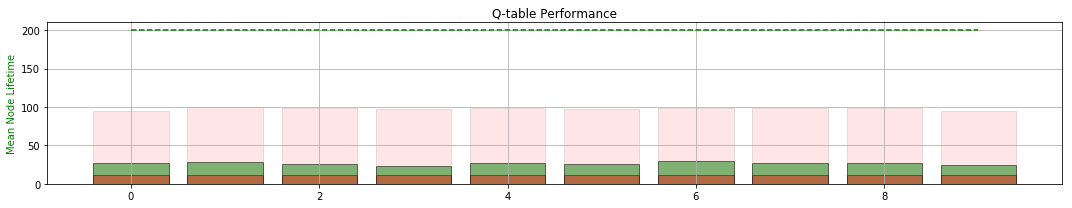

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.988	LOSS : 1.856	LOSS : 1.780	LOSS : 2.248	LOSS : 1.897	LOSS : 1.835	LOSS : 1.970	LOSS : 2.198	LOSS : 1.953	LOSS : 2.068	LOSS : 2.085	LOSS : 2.212	LOSS : 1.917	LOSS : 2.045	LOSS : 2.226	LOSS : 2.054	LOSS : 2.010	LOSS : 2.301	LOSS : 1.878	LOSS : 2.029	LOSS : 2.303	LOSS : 2.514	LOSS : 2.307	LOSS : 2.584	LOSS : 1.861	LOSS : 2.260	LOSS : 1.807	LOSS : 2.377	LOSS : 2.198	LOSS : 2.033	
Validating... MEAN TIME:  106.78
LOSS : 1.924	LOSS : 1.837	LOSS : 1.659	LOSS : 1.824	LOSS : 1.756	LOSS : 2.189	LOSS : 1.845	LOSS : 2.143	LOSS : 2.318	LOSS : 2.099	LOSS : 2.084	LOSS : 2.201	LOSS : 2.076	LOSS : 1.996	LOSS : 2.276	LOSS : 1.586	LOSS : 1.557	LOSS : 2.027	LOSS : 2.260	LOSS : 2.030	LOSS : 1.986	LOSS : 2.225	LOSS : 1.965	LOSS : 2.110	LOSS : 2.176	LOSS : 2.117	LOSS : 2.344	LOSS : 2.180	LOSS : 2.007	LOSS : 2.508	
Validating... MEAN TIME:  104.725
LOSS : 2.088	LOSS : 1.

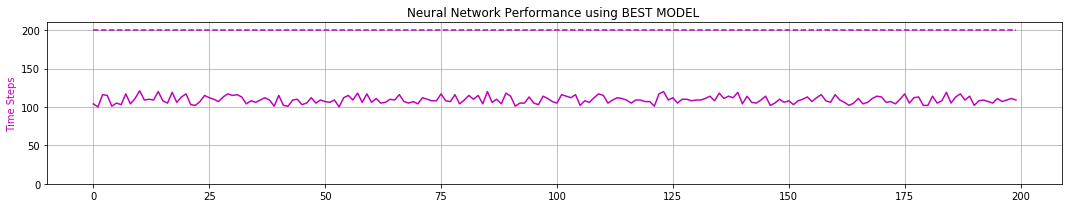

peak memory: 1460.09 MiB, increment: 1016.32 MiB
0 -max- [ 0.201  0.989  0.049  0.620]
0 -min- [-2.395 -2.952 -0.209 -1.453]

1 -max- [ 0.204  0.983  0.047  0.684]
1 -min- [-2.396 -2.959 -0.209 -1.470]

2 -max- [ 0.208  0.973  0.049  0.677]
2 -min- [-2.388 -2.960 -0.209 -1.387]

3 -max- [ 0.176  1.014  0.050  0.570]
3 -min- [-2.399 -2.939 -0.209 -1.637]

4 -max- [ 0.195  1.122  0.050  0.631]
4 -min- [-2.398 -2.957 -0.209 -1.652]

5 -max- [ 0.195  1.146  0.050  0.601]
5 -min- [-2.395 -3.142 -0.209 -1.656]

6 -max- [ 0.213  0.991  0.049  0.665]
6 -min- [-2.399 -2.963 -0.209 -1.369]

7 -max- [ 0.198  0.976  0.049  0.616]
7 -min- [-2.390 -2.957 -0.209 -1.462]

8 -max- [ 0.200  1.197  0.050  0.625]
8 -min- [-2.399 -2.967 -0.209 -1.622]

9 -max- [ 0.214  0.833  0.049  0.690]
9 -min- [-2.395 -2.961 -0.209 -1.393]

Quantization TIME:  0.02 minutes


ITERATION # 18
SMALLEST TIMESTEP in ITERATION 18: 11
REAL TIME TO GENERATE 31737 EXPERIENCES:0:00:00.803084


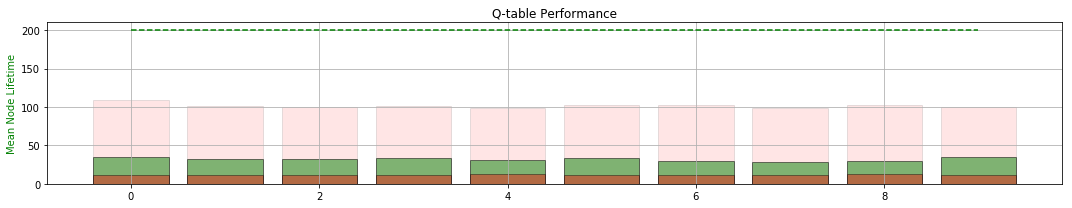

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.635	LOSS : 2.564	LOSS : 2.090	LOSS : 2.565	LOSS : 2.260	LOSS : 2.145	LOSS : 2.204	LOSS : 1.898	LOSS : 2.581	LOSS : 2.087	LOSS : 2.527	LOSS : 2.396	LOSS : 1.957	LOSS : 2.340	LOSS : 2.034	LOSS : 2.236	LOSS : 2.774	LOSS : 2.406	LOSS : 2.663	LOSS : 2.339	LOSS : 2.411	LOSS : 2.111	LOSS : 2.184	LOSS : 2.299	LOSS : 2.632	LOSS : 1.839	LOSS : 2.391	LOSS : 2.452	LOSS : 2.444	LOSS : 2.190	
Validating... MEAN TIME:  111.545
LOSS : 2.108	LOSS : 2.443	LOSS : 2.273	LOSS : 2.322	LOSS : 2.489	LOSS : 2.177	LOSS : 2.592	LOSS : 2.335	LOSS : 2.152	LOSS : 2.330	LOSS : 2.536	LOSS : 2.190	LOSS : 2.920	LOSS : 2.044	LOSS : 2.217	LOSS : 2.381	LOSS : 2.467	LOSS : 2.233	LOSS : 2.416	LOSS : 2.435	LOSS : 1.780	LOSS : 2.059	LOSS : 2.374	LOSS : 2.447	LOSS : 2.228	LOSS : 2.279	LOSS : 2.084	LOSS : 1.773	LOSS : 2.734	LOSS : 2.441	
Validating... MEAN TIME:  107.4
LOSS : 1.597	LOSS : 2.1

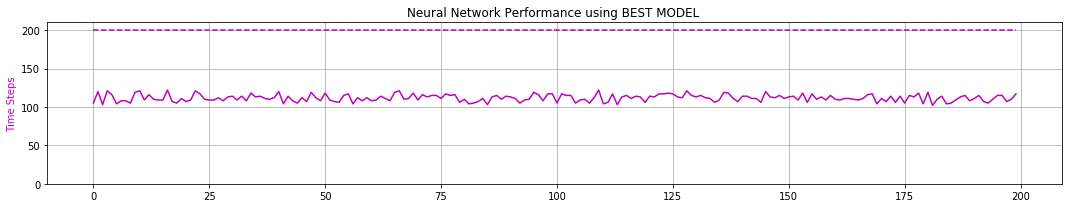

peak memory: 1432.17 MiB, increment: 987.66 MiB
0 -max- [ 0.201  0.983  0.047  0.636]
0 -min- [-2.400 -2.937 -0.209 -1.495]

1 -max- [ 0.200  1.011  0.049  0.812]
1 -min- [-2.397 -2.865 -0.209 -1.454]

2 -max- [ 0.176  0.957  0.051  0.642]
2 -min- [-2.395 -2.955 -0.209 -1.414]

3 -max- [ 0.195  0.964  0.050  0.644]
3 -min- [-2.395 -2.947 -0.209 -1.448]

4 -max- [ 0.191  0.967  0.050  0.620]
4 -min- [-2.398 -2.769 -0.209 -1.380]

5 -max- [ 0.200  1.001  0.049  0.645]
5 -min- [-2.384 -2.937 -0.209 -1.411]

6 -max- [ 0.198  0.830  0.049  0.620]
6 -min- [-2.393 -2.946 -0.209 -1.375]

7 -max- [ 0.213  1.015  0.050  0.621]
7 -min- [-2.399 -2.891 -0.209 -1.439]

8 -max- [ 0.195  0.964  0.049  0.630]
8 -min- [-2.391 -2.867 -0.209 -1.463]

9 -max- [ 0.178  0.988  0.049  0.735]
9 -min- [-2.399 -2.881 -0.209 -1.461]

Quantization TIME:  0.01 minutes


ITERATION # 19
SMALLEST TIMESTEP in ITERATION 19: 11
REAL TIME TO GENERATE 37129 EXPERIENCES:0:00:01.048303


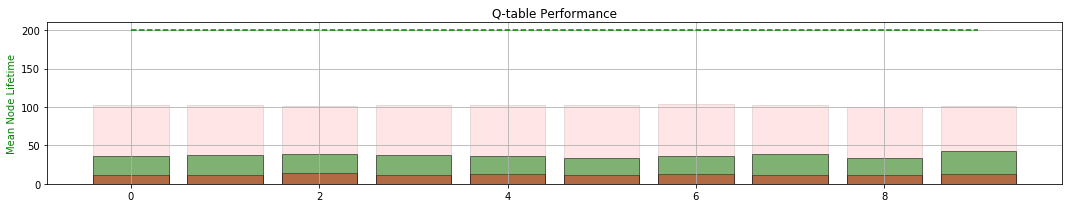

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.129	LOSS : 2.941	LOSS : 2.475	LOSS : 2.728	LOSS : 2.817	LOSS : 1.803	LOSS : 2.433	LOSS : 2.538	LOSS : 2.622	LOSS : 2.679	LOSS : 2.221	LOSS : 2.340	LOSS : 2.354	LOSS : 2.641	LOSS : 2.619	LOSS : 2.742	LOSS : 1.980	LOSS : 2.163	LOSS : 2.722	LOSS : 2.333	LOSS : 2.774	LOSS : 2.461	LOSS : 2.921	LOSS : 2.517	LOSS : 2.120	LOSS : 2.595	LOSS : 2.686	LOSS : 2.749	LOSS : 2.514	LOSS : 2.618	
Validating... MEAN TIME:  104.35
LOSS : 2.220	LOSS : 2.245	LOSS : 2.115	LOSS : 2.759	LOSS : 2.146	LOSS : 2.732	LOSS : 2.017	LOSS : 2.971	LOSS : 2.119	LOSS : 2.443	LOSS : 2.616	LOSS : 2.466	LOSS : 2.368	LOSS : 2.147	LOSS : 2.588	LOSS : 2.446	LOSS : 2.532	LOSS : 2.103	LOSS : 2.388	LOSS : 2.522	LOSS : 2.376	LOSS : 2.946	LOSS : 2.252	LOSS : 2.311	LOSS : 2.512	LOSS : 2.441	LOSS : 2.218	LOSS : 2.913	LOSS : 2.973	LOSS : 3.188	
Validating... MEAN TIME:  98.17
LOSS : 2.695	LOSS : 2.41

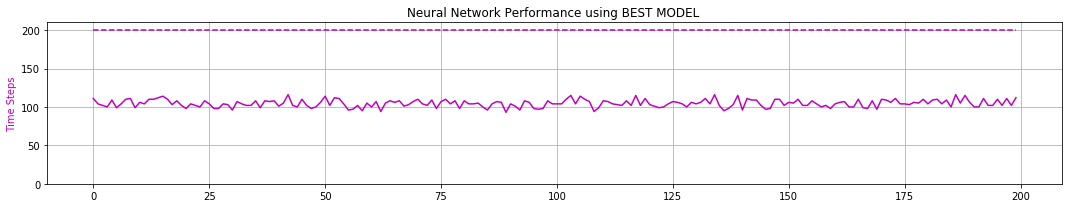

peak memory: 1416.56 MiB, increment: 1016.32 MiB
0 -max- [ 0.195  0.965  0.049  0.807]
0 -min- [-2.391 -2.776 -0.209 -1.409]

1 -max- [ 0.168  0.826  0.050  1.040]
1 -min- [-2.370 -2.770 -0.209 -1.425]

2 -max- [ 0.187  0.927  0.050  0.675]
2 -min- [-2.398 -2.765 -0.209 -1.368]

3 -max- [ 0.183  0.967  0.050  0.817]
3 -min- [-2.393 -2.778 -0.209 -1.385]

4 -max- [ 0.200  0.991  0.049  0.769]
4 -min- [-2.392 -2.760 -0.209 -1.464]

5 -max- [ 0.198  0.976  0.049  0.714]
5 -min- [-2.397 -2.779 -0.209 -1.456]

6 -max- [ 0.200  1.150  0.068  0.681]
6 -min- [-2.397 -2.772 -0.209 -1.606]

7 -max- [ 0.198  0.954  0.049  0.685]
7 -min- [-2.382 -2.771 -0.209 -1.435]

8 -max- [ 0.178  1.003  0.049  0.659]
8 -min- [-2.386 -2.779 -0.209 -1.425]

9 -max- [ 0.202  0.828  0.050  0.848]
9 -min- [-2.396 -2.747 -0.209 -1.336]

Quantization TIME:  0.01 minutes


ITERATION # 20
SMALLEST TIMESTEP in ITERATION 20: 12
REAL TIME TO GENERATE 60725 EXPERIENCES:0:00:01.598807


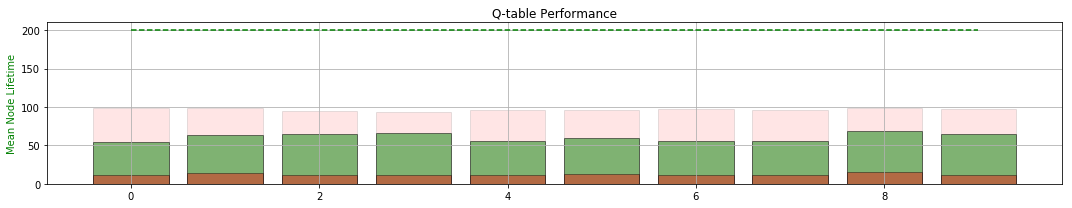

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.739	LOSS : 2.168	LOSS : 2.013	LOSS : 2.214	LOSS : 2.190	LOSS : 2.270	LOSS : 2.687	LOSS : 2.473	LOSS : 2.543	LOSS : 2.618	LOSS : 2.601	LOSS : 2.099	LOSS : 2.377	LOSS : 2.610	LOSS : 2.575	LOSS : 2.234	LOSS : 2.250	LOSS : 1.979	LOSS : 2.341	LOSS : 1.959	LOSS : 2.902	LOSS : 2.600	LOSS : 2.286	LOSS : 2.230	LOSS : 2.870	LOSS : 2.552	LOSS : 2.299	LOSS : 2.410	LOSS : 2.678	LOSS : 2.716	
Validating... MEAN TIME:  96.235
LOSS : 2.345	LOSS : 2.250	LOSS : 2.742	LOSS : 2.648	LOSS : 2.727	LOSS : 2.382	LOSS : 2.528	LOSS : 2.511	LOSS : 2.451	LOSS : 2.678	LOSS : 2.302	LOSS : 2.198	LOSS : 2.742	LOSS : 2.517	LOSS : 2.456	LOSS : 2.373	LOSS : 2.423	LOSS : 2.636	LOSS : 2.289	LOSS : 2.203	LOSS : 2.038	LOSS : 2.541	LOSS : 1.949	LOSS : 1.916	LOSS : 2.071	LOSS : 2.417	LOSS : 2.168	LOSS : 2.271	LOSS : 2.869	LOSS : 3.124	
Validating... MEAN TIME:  96.305
LOSS : 2.307	LOSS : 2.7

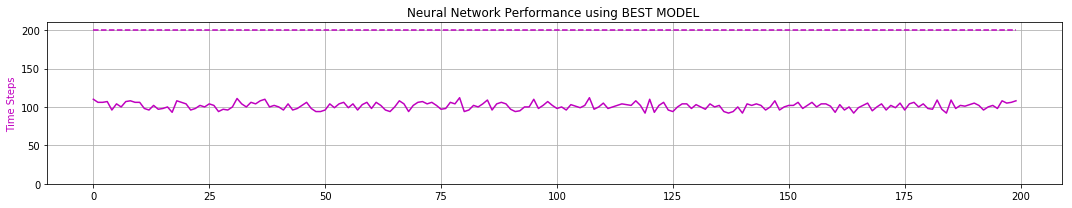

peak memory: 1412.32 MiB, increment: 1017.48 MiB
0 -max- [ 0.171  1.021  0.052  0.872]
0 -min- [-2.235 -2.709 -0.209 -1.431]

1 -max- [ 0.187  1.122  0.050  0.787]
1 -min- [-2.185 -2.728 -0.209 -1.652]

2 -max- [ 0.183  1.146  0.050  0.687]
2 -min- [-2.147 -2.779 -0.209 -1.661]

3 -max- [ 0.200  1.004  0.049  0.688]
3 -min- [-2.093 -2.700 -0.209 -1.734]

4 -max- [ 0.198  0.830  0.049  0.669]
4 -min- [-2.063 -2.596 -0.209 -1.372]

5 -max- [ 0.200  1.153  0.050  0.759]
5 -min- [-2.212 -2.886 -0.209 -1.642]

6 -max- [ 0.198  1.005  0.049  0.863]
6 -min- [-2.144 -2.588 -0.209 -1.517]

7 -max- [ 0.178  0.988  0.049  0.790]
7 -min- [-2.165 -2.735 -0.209 -1.446]

8 -max- [ 0.209  1.150  0.050  0.928]
8 -min- [-2.170 -2.688 -0.209 -1.657]

9 -max- [ 0.195  1.187  0.050  0.832]
9 -min- [-2.229 -2.705 -0.209 -1.654]

Quantization TIME:  0.02 minutes


ITERATION # 21
SMALLEST TIMESTEP in ITERATION 21: 10
REAL TIME TO GENERATE 38268 EXPERIENCES:0:00:01.017681


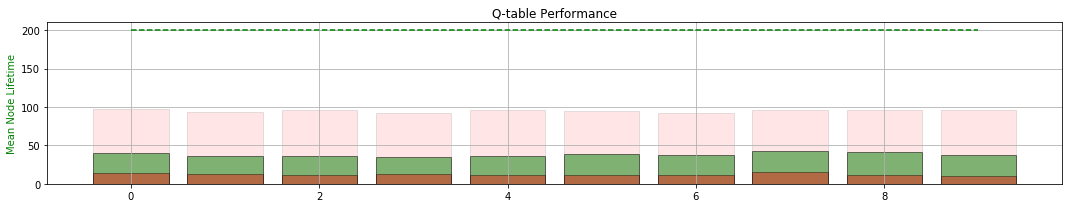

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.720	LOSS : 2.608	LOSS : 2.571	LOSS : 2.381	LOSS : 2.597	LOSS : 2.527	LOSS : 2.334	LOSS : 2.653	LOSS : 2.541	LOSS : 2.747	LOSS : 2.448	LOSS : 2.419	LOSS : 2.632	LOSS : 2.150	LOSS : 2.195	LOSS : 2.323	LOSS : 2.358	LOSS : 2.652	LOSS : 2.272	LOSS : 2.507	LOSS : 2.376	LOSS : 2.699	LOSS : 2.148	LOSS : 2.299	LOSS : 2.469	LOSS : 2.536	LOSS : 2.493	LOSS : 2.254	LOSS : 2.088	LOSS : 2.054	
Validating... MEAN TIME:  100.685
LOSS : 2.734	LOSS : 2.783	LOSS : 2.291	LOSS : 2.772	LOSS : 2.845	LOSS : 2.796	LOSS : 2.528	LOSS : 2.571	LOSS : 2.933	LOSS : 2.426	LOSS : 2.514	LOSS : 2.756	LOSS : 2.417	LOSS : 3.097	LOSS : 3.055	LOSS : 2.329	LOSS : 2.502	LOSS : 2.747	LOSS : 2.502	LOSS : 2.187	LOSS : 2.542	LOSS : 2.689	LOSS : 2.636	LOSS : 3.054	LOSS : 2.748	LOSS : 2.308	LOSS : 2.812	LOSS : 2.385	LOSS : 2.731	LOSS : 2.254	
Validating... MEAN TIME:  101.35
LOSS : 2.762	LOSS : 2.

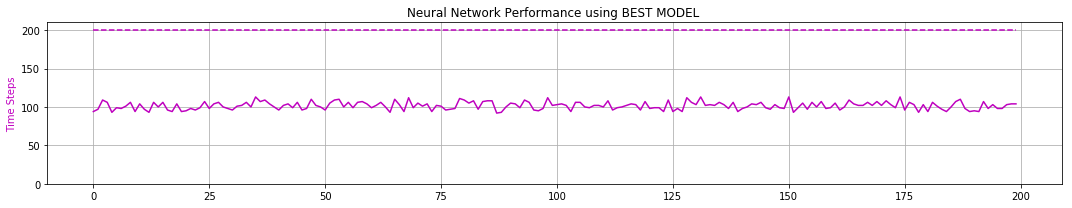

peak memory: 1461.15 MiB, increment: 1017.61 MiB
0 -max- [ 0.187  0.927  0.050  0.603]
0 -min- [-2.241 -3.078 -0.209 -1.368]

1 -max- [ 0.179  0.966  0.050  0.616]
1 -min- [-2.276 -2.969 -0.209 -1.364]

2 -max- [ 0.197  1.002  0.049  0.605]
2 -min- [-2.374 -3.138 -0.209 -1.464]

3 -max- [ 0.190  0.966  0.054  0.556]
3 -min- [-2.203 -2.929 -0.209 -1.379]

4 -max- [ 0.192  0.959  0.051  0.606]
4 -min- [-2.226 -2.945 -0.209 -1.489]

5 -max- [ 0.190  0.828  0.049  0.786]
5 -min- [-2.216 -2.940 -0.209 -1.405]

6 -max- [ 0.178  0.950  0.049  0.610]
6 -min- [-2.149 -2.944 -0.209 -1.463]

7 -max- [ 0.195  1.004  0.055  0.620]
7 -min- [-2.222 -3.085 -0.209 -1.353]

8 -max- [ 0.188  1.019  0.049  0.722]
8 -min- [-2.336 -3.096 -0.209 -1.639]

9 -max- [ 0.193  0.959  0.048  0.624]
9 -min- [-2.385 -3.144 -0.209 -1.612]

Quantization TIME:  0.01 minutes


ITERATION # 22
SMALLEST TIMESTEP in ITERATION 22: 11
REAL TIME TO GENERATE 38872 EXPERIENCES:0:00:01.030605


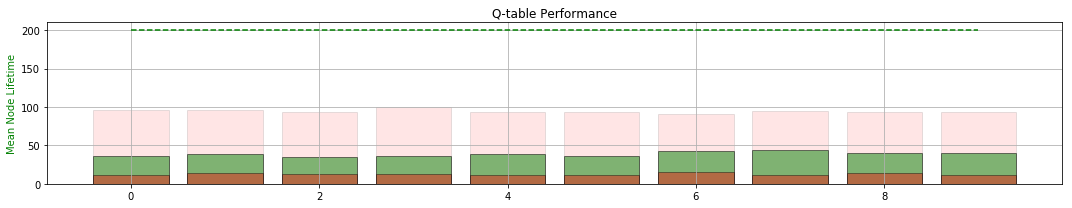

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.672	LOSS : 2.698	LOSS : 2.700	LOSS : 2.796	LOSS : 2.734	LOSS : 2.541	LOSS : 2.627	LOSS : 2.534	LOSS : 2.805	LOSS : 2.796	LOSS : 2.556	LOSS : 2.935	LOSS : 2.908	LOSS : 2.793	LOSS : 2.909	LOSS : 2.698	LOSS : 2.600	LOSS : 2.725	LOSS : 2.598	LOSS : 2.701	LOSS : 2.254	LOSS : 2.833	LOSS : 2.329	LOSS : 2.549	LOSS : 3.086	LOSS : 2.660	LOSS : 2.898	LOSS : 2.969	LOSS : 2.587	LOSS : 2.614	
Validating... MEAN TIME:  100.98
LOSS : 2.197	LOSS : 2.655	LOSS : 2.579	LOSS : 2.728	LOSS : 2.626	LOSS : 2.761	LOSS : 3.255	LOSS : 2.534	LOSS : 2.801	LOSS : 2.380	LOSS : 3.058	LOSS : 2.448	LOSS : 3.010	LOSS : 2.526	LOSS : 2.708	LOSS : 2.421	LOSS : 2.521	LOSS : 2.673	LOSS : 3.120	LOSS : 2.600	LOSS : 2.852	LOSS : 2.367	LOSS : 2.485	LOSS : 2.643	LOSS : 2.281	LOSS : 2.584	LOSS : 2.830	LOSS : 2.970	LOSS : 2.731	LOSS : 2.510	
Validating... MEAN TIME:  101.53
LOSS : 2.542	LOSS : 2.3

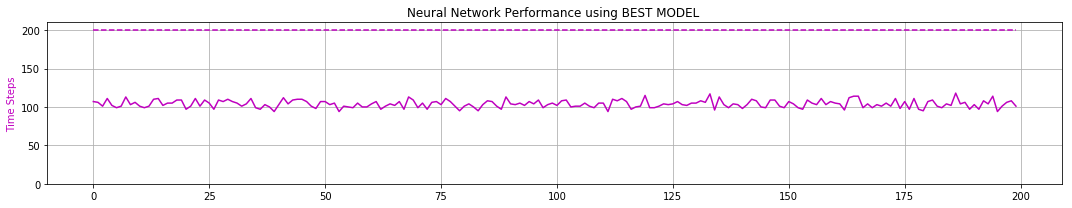

peak memory: 1423.66 MiB, increment: 978.09 MiB
0 -max- [ 0.179  0.966  0.050  0.569]
0 -min- [-2.230 -3.085 -0.209 -1.377]

1 -max- [ 0.197  1.014  0.049  0.574]
1 -min- [-2.165 -2.938 -0.209 -1.462]

2 -max- [ 0.190  0.940  0.049  0.550]
2 -min- [-1.979 -2.920 -0.209 -1.419]

3 -max- [ 0.200  0.958  0.050  0.596]
3 -min- [-2.300 -3.082 -0.209 -1.347]

4 -max- [ 0.190  0.828  0.049  0.578]
4 -min- [-2.282 -2.937 -0.209 -1.269]

5 -max- [ 0.188  1.027  0.049  0.796]
5 -min- [-2.253 -2.972 -0.209 -1.521]

6 -max- [ 0.195  0.956  0.050  0.594]
6 -min- [-2.089 -2.899 -0.209 -1.439]

7 -max- [ 0.193  1.004  0.049  0.601]
7 -min- [-2.392 -3.098 -0.209 -1.375]

8 -max- [ 0.198  1.012  0.048  0.569]
8 -min- [-2.181 -2.937 -0.209 -1.413]

9 -max- [ 0.191  1.008  0.050  0.599]
9 -min- [-2.106 -2.936 -0.209 -1.461]

Quantization TIME:  0.02 minutes


ITERATION # 23
SMALLEST TIMESTEP in ITERATION 23: 11
REAL TIME TO GENERATE 47057 EXPERIENCES:0:00:01.899246


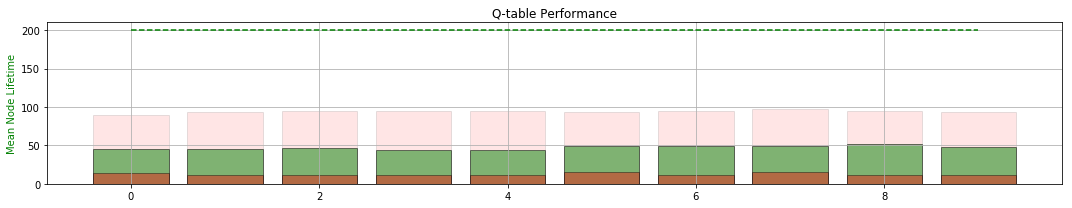

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.772	LOSS : 2.472	LOSS : 2.897	LOSS : 2.807	LOSS : 2.503	LOSS : 2.643	LOSS : 2.445	LOSS : 2.543	LOSS : 2.889	LOSS : 2.604	LOSS : 2.853	LOSS : 2.492	LOSS : 2.575	LOSS : 2.962	LOSS : 2.557	LOSS : 2.713	LOSS : 2.688	LOSS : 2.707	LOSS : 2.716	LOSS : 2.162	LOSS : 2.231	LOSS : 2.714	LOSS : 2.415	LOSS : 2.456	LOSS : 2.746	LOSS : 2.686	LOSS : 2.474	LOSS : 2.768	LOSS : 2.669	LOSS : 2.761	
Validating... MEAN TIME:  103.96
LOSS : 2.641	LOSS : 2.750	LOSS : 2.762	LOSS : 2.712	LOSS : 2.550	LOSS : 2.941	LOSS : 2.756	LOSS : 2.836	LOSS : 2.751	LOSS : 2.647	LOSS : 3.073	LOSS : 2.449	LOSS : 2.829	LOSS : 2.786	LOSS : 2.864	LOSS : 2.693	LOSS : 2.891	LOSS : 2.899	LOSS : 2.230	LOSS : 3.055	LOSS : 2.755	LOSS : 2.921	LOSS : 2.622	LOSS : 2.751	LOSS : 2.553	LOSS : 2.887	LOSS : 2.661	LOSS : 2.575	LOSS : 2.571	LOSS : 2.803	
Validating... MEAN TIME:  105.035
LOSS : 2.732	LOSS : 2.

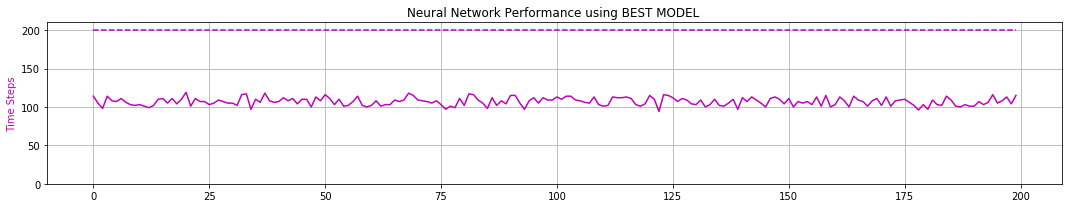

peak memory: 1425.98 MiB, increment: 1054.71 MiB
0 -max- [ 0.197  0.990  0.049  0.714]
0 -min- [-2.158 -2.888 -0.209 -1.425]

1 -max- [ 0.190  0.985  0.049  0.580]
1 -min- [-2.153 -3.071 -0.209 -1.617]

2 -max- [ 0.192  0.946  0.050  0.724]
2 -min- [-2.189 -2.970 -0.209 -1.397]

3 -max- [ 0.190  0.828  0.049  0.580]
3 -min- [-2.263 -3.087 -0.209 -1.422]

4 -max- [ 0.170  0.937  0.049  0.780]
4 -min- [-2.210 -2.931 -0.209 -1.460]

5 -max- [ 0.195  0.827  0.050  0.594]
5 -min- [-1.997 -2.917 -0.209 -1.274]

6 -max- [ 0.194  1.199  0.049  0.602]
6 -min- [-2.373 -3.100 -0.209 -1.657]

7 -max- [ 0.198  0.939  0.048  0.599]
7 -min- [-2.165 -2.922 -0.209 -1.365]

8 -max- [ 0.191  1.008  0.050  0.629]
8 -min- [-2.158 -2.908 -0.209 -1.360]

9 -max- [ 0.193  0.824  0.048  0.608]
9 -min- [-2.105 -2.910 -0.209 -1.400]

Quantization TIME:  0.01 minutes


ITERATION # 24
SMALLEST TIMESTEP in ITERATION 24: 11
REAL TIME TO GENERATE 53901 EXPERIENCES:0:00:01.381675


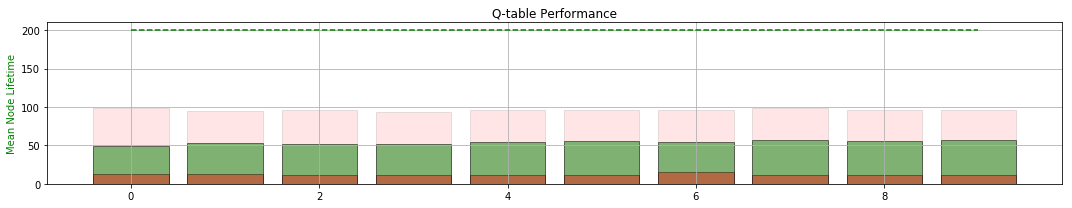

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.530	LOSS : 2.472	LOSS : 2.372	LOSS : 2.199	LOSS : 2.706	LOSS : 2.341	LOSS : 2.480	LOSS : 2.619	LOSS : 1.987	LOSS : 2.623	LOSS : 2.377	LOSS : 2.279	LOSS : 2.518	LOSS : 2.362	LOSS : 2.426	LOSS : 2.520	LOSS : 2.683	LOSS : 2.342	LOSS : 2.087	LOSS : 2.150	LOSS : 2.631	LOSS : 2.730	LOSS : 2.255	LOSS : 2.363	LOSS : 2.319	LOSS : 2.517	LOSS : 2.697	LOSS : 2.508	LOSS : 2.434	LOSS : 2.584	
Validating... MEAN TIME:  104.42
LOSS : 2.410	LOSS : 2.800	LOSS : 2.387	LOSS : 2.695	LOSS : 2.417	LOSS : 2.701	LOSS : 2.587	LOSS : 2.617	LOSS : 2.489	LOSS : 2.260	LOSS : 2.274	LOSS : 2.476	LOSS : 2.347	LOSS : 2.443	LOSS : 2.632	LOSS : 2.669	LOSS : 2.740	LOSS : 2.286	LOSS : 2.318	LOSS : 2.502	LOSS : 2.502	LOSS : 2.562	LOSS : 2.418	LOSS : 2.273	LOSS : 2.022	LOSS : 2.202	LOSS : 2.510	LOSS : 2.379	LOSS : 2.284	LOSS : 2.538	
Validating... MEAN TIME:  104.04
LOSS : 2.453	LOSS : 2.2

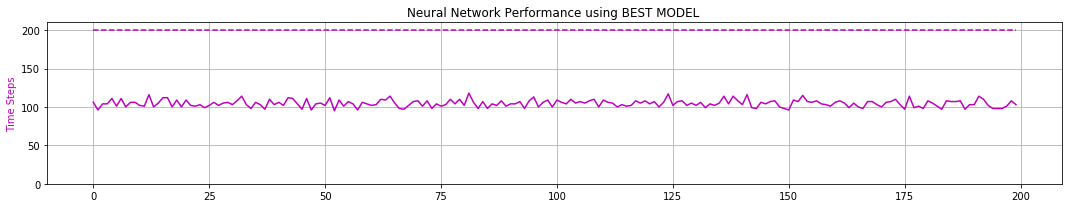

peak memory: 1447.12 MiB, increment: 1017.25 MiB
0 -max- [ 0.190  1.016  0.049  0.608]
0 -min- [-2.386 -3.081 -0.209 -1.487]

1 -max- [ 0.192  1.124  0.050  0.621]
1 -min- [-2.270 -2.925 -0.209 -1.623]

2 -max- [ 0.190  0.828  0.049  0.628]
2 -min- [-2.242 -2.942 -0.209 -1.218]

3 -max- [ 0.178  1.017  0.049  0.612]
3 -min- [-2.270 -3.146 -0.209 -1.461]

4 -max- [ 0.195  0.991  0.050  0.564]
4 -min- [-2.274 -3.145 -0.209 -1.423]

5 -max- [ 0.205  1.199  0.049  0.606]
5 -min- [-2.249 -3.111 -0.209 -1.657]

6 -max- [ 0.193  1.134  0.048  0.616]
6 -min- [-2.326 -3.071 -0.209 -1.661]

7 -max- [ 0.199  1.008  0.050  0.605]
7 -min- [-2.282 -3.081 -0.209 -1.360]

8 -max- [ 0.193  0.992  0.048  1.026]
8 -min- [-2.278 -2.951 -0.209 -1.412]

9 -max- [ 0.200  1.017  0.050  0.615]
9 -min- [-2.242 -2.939 -0.209 -1.462]

Quantization TIME:  0.01 minutes


ITERATION # 25
SMALLEST TIMESTEP in ITERATION 25: 12
REAL TIME TO GENERATE 49241 EXPERIENCES:0:00:01.269707


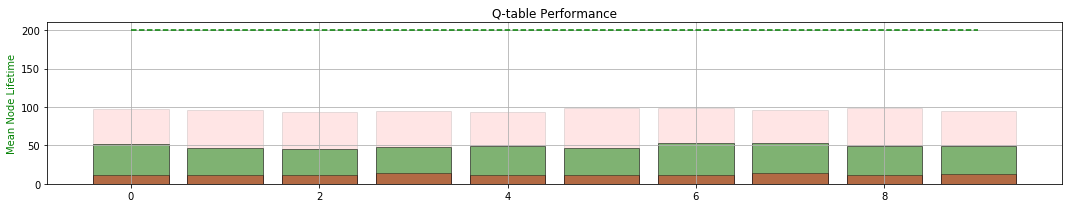

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.911	LOSS : 2.441	LOSS : 2.394	LOSS : 2.578	LOSS : 2.256	LOSS : 2.325	LOSS : 2.269	LOSS : 2.361	LOSS : 2.184	LOSS : 2.227	LOSS : 2.138	LOSS : 2.252	LOSS : 2.375	LOSS : 2.595	LOSS : 2.187	LOSS : 1.872	LOSS : 2.284	LOSS : 2.461	LOSS : 2.414	LOSS : 2.441	LOSS : 2.333	LOSS : 1.940	LOSS : 2.245	LOSS : 2.328	LOSS : 2.682	LOSS : 1.773	LOSS : 2.561	LOSS : 2.388	LOSS : 2.326	LOSS : 2.107	
Validating... MEAN TIME:  101.87
LOSS : 2.507	LOSS : 2.047	LOSS : 2.100	LOSS : 2.195	LOSS : 2.331	LOSS : 2.754	LOSS : 2.629	LOSS : 2.459	LOSS : 2.685	LOSS : 2.292	LOSS : 2.273	LOSS : 2.449	LOSS : 2.207	LOSS : 2.460	LOSS : 2.076	LOSS : 2.315	LOSS : 2.433	LOSS : 1.807	LOSS : 2.164	LOSS : 2.023	LOSS : 2.320	LOSS : 2.497	LOSS : 2.099	LOSS : 2.111	LOSS : 2.094	LOSS : 2.047	LOSS : 2.317	LOSS : 2.093	LOSS : 2.346	LOSS : 2.096	
Validating... MEAN TIME:  100.275
LOSS : 2.466	LOSS : 2.

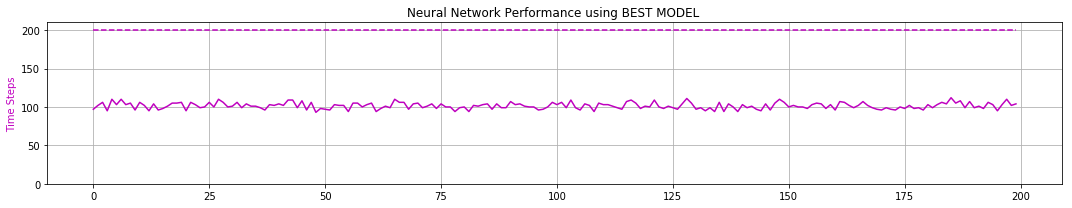

peak memory: 1464.36 MiB, increment: 1017.14 MiB
0 -max- [ 0.202  0.948  0.050  0.610]
0 -min- [-2.387 -3.113 -0.209 -1.444]

1 -max- [ 0.198  0.977  0.049  0.585]
1 -min- [-2.372 -3.155 -0.209 -1.452]

2 -max- [ 0.183  1.000  0.049  0.730]
2 -min- [-2.382 -3.152 -0.209 -1.498]

3 -max- [ 0.195  0.827  0.050  0.607]
3 -min- [-2.356 -3.141 -0.209 -1.358]

4 -max- [ 0.195  1.199  0.054  0.742]
4 -min- [-2.345 -3.087 -0.209 -1.657]

5 -max- [ 0.214  0.970  0.048  0.600]
5 -min- [-2.350 -3.148 -0.209 -1.517]

6 -max- [ 0.198  1.008  0.050  0.602]
6 -min- [-2.350 -3.262 -0.209 -1.476]

7 -max- [ 0.201  0.825  0.048  0.594]
7 -min- [-2.396 -3.249 -0.209 -1.377]

8 -max- [ 0.213  1.205  0.050  0.600]
8 -min- [-2.360 -3.266 -0.209 -1.742]

9 -max- [ 0.200  1.210  0.057  0.610]
9 -min- [-2.386 -3.154 -0.209 -1.658]

Quantization TIME:  0.02 minutes


ITERATION # 26
SMALLEST TIMESTEP in ITERATION 26: 11
REAL TIME TO GENERATE 25504 EXPERIENCES:0:00:00.662018


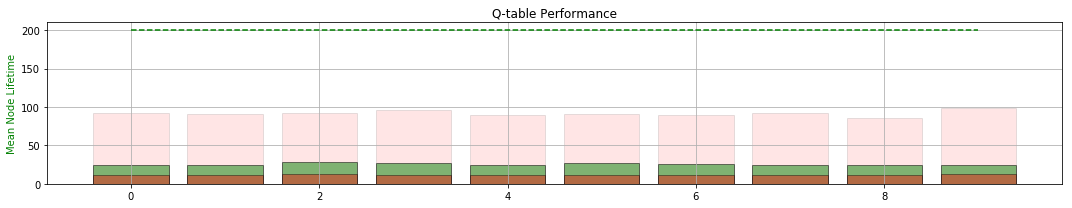

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.628	LOSS : 2.315	LOSS : 2.578	LOSS : 2.522	LOSS : 2.367	LOSS : 2.765	LOSS : 2.529	LOSS : 1.970	LOSS : 2.364	LOSS : 2.550	LOSS : 2.666	LOSS : 2.645	LOSS : 2.196	LOSS : 2.597	LOSS : 2.512	LOSS : 2.535	LOSS : 2.027	LOSS : 2.199	LOSS : 2.720	LOSS : 2.354	LOSS : 2.573	LOSS : 1.935	LOSS : 2.660	LOSS : 2.432	LOSS : 2.390	LOSS : 2.264	LOSS : 2.451	LOSS : 2.294	LOSS : 2.338	LOSS : 2.370	
Validating... MEAN TIME:  101.23
LOSS : 2.580	LOSS : 2.424	LOSS : 2.274	LOSS : 2.427	LOSS : 2.510	LOSS : 2.312	LOSS : 2.288	LOSS : 2.408	LOSS : 2.529	LOSS : 2.473	LOSS : 2.515	LOSS : 2.394	LOSS : 2.481	LOSS : 2.497	LOSS : 2.330	LOSS : 2.491	LOSS : 2.196	LOSS : 2.765	LOSS : 2.672	LOSS : 2.394	LOSS : 2.408	LOSS : 2.326	LOSS : 2.404	LOSS : 2.275	LOSS : 2.442	LOSS : 2.334	LOSS : 2.513	LOSS : 2.440	LOSS : 2.264	LOSS : 2.398	
Validating... MEAN TIME:  100.81
LOSS : 2.339	LOSS : 2.2

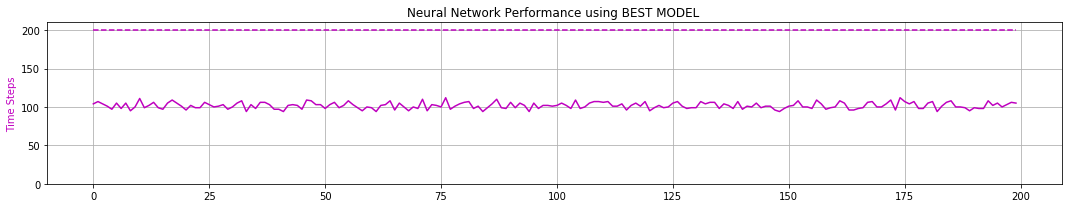

peak memory: 1455.68 MiB, increment: 1000.48 MiB
0 -max- [ 0.208  1.125  0.049  0.558]
0 -min- [-2.372 -3.151 -0.209 -1.711]

1 -max- [ 0.199  0.988  0.049  0.753]
1 -min- [-1.988 -2.950 -0.209 -1.508]

2 -max- [ 0.202  1.008  0.050  0.595]
2 -min- [-2.349 -3.152 -0.209 -1.464]

3 -max- [ 0.195  1.199  0.049  0.568]
3 -min- [-2.376 -3.149 -0.209 -1.657]

4 -max- [ 0.214  0.968  0.048  0.541]
4 -min- [-2.229 -3.141 -0.209 -1.466]

5 -max- [ 0.215  1.008  0.050  0.588]
5 -min- [-2.235 -3.090 -0.209 -1.417]

6 -max- [ 0.211  1.142  0.048  0.552]
6 -min- [-1.968 -2.968 -0.209 -1.665]

7 -max- [ 0.215  1.017  0.050  0.613]
7 -min- [-2.210 -2.964 -0.209 -1.373]

8 -max- [ 0.202  1.158  0.050  0.508]
8 -min- [-2.201 -2.907 -0.209 -1.655]

9 -max- [ 0.205  0.996  0.049  0.599]
9 -min- [-2.378 -3.256 -0.209 -1.382]

Quantization TIME:  0.02 minutes


ITERATION # 27
SMALLEST TIMESTEP in ITERATION 27: 11
REAL TIME TO GENERATE 25711 EXPERIENCES:0:00:00.715588


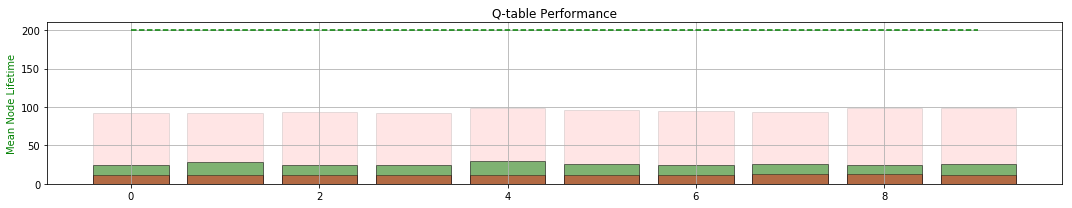

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.334	LOSS : 2.306	LOSS : 2.226	LOSS : 2.717	LOSS : 2.539	LOSS : 2.556	LOSS : 2.517	LOSS : 2.474	LOSS : 2.645	LOSS : 2.070	LOSS : 2.536	LOSS : 2.502	LOSS : 2.388	LOSS : 2.357	LOSS : 2.255	LOSS : 2.327	LOSS : 2.608	LOSS : 2.820	LOSS : 2.492	LOSS : 2.739	LOSS : 2.610	LOSS : 3.081	LOSS : 2.629	LOSS : 2.358	LOSS : 2.554	LOSS : 2.665	LOSS : 2.588	LOSS : 2.651	LOSS : 2.908	LOSS : 2.682	
Validating... MEAN TIME:  103.6
LOSS : 2.536	LOSS : 2.779	LOSS : 2.125	LOSS : 2.659	LOSS : 2.400	LOSS : 2.616	LOSS : 2.296	LOSS : 2.543	LOSS : 2.335	LOSS : 2.758	LOSS : 2.654	LOSS : 2.469	LOSS : 2.523	LOSS : 2.607	LOSS : 2.539	LOSS : 2.371	LOSS : 2.773	LOSS : 2.715	LOSS : 2.750	LOSS : 2.480	LOSS : 2.614	LOSS : 2.904	LOSS : 2.550	LOSS : 2.739	LOSS : 2.545	LOSS : 2.263	LOSS : 2.292	LOSS : 2.327	LOSS : 2.498	LOSS : 2.192	
Validating... MEAN TIME:  101.08
LOSS : 2.926	LOSS : 2.96

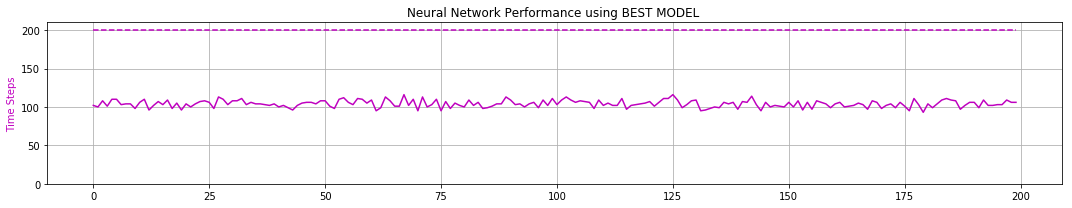

peak memory: 1453.04 MiB, increment: 1083.93 MiB
0 -max- [ 0.199  1.172  0.049  0.631]
0 -min- [-2.182 -2.959 -0.209 -1.652]

1 -max- [ 0.202  1.006  0.050  0.616]
1 -min- [-2.349 -3.152 -0.209 -1.481]

2 -max- [ 0.216  1.199  0.049  0.600]
2 -min- [-2.271 -2.947 -0.209 -1.657]

3 -max- [ 0.221  0.980  0.051  0.382]
3 -min- [-2.393 -3.333 -0.209 -1.450]

4 -max- [ 0.218  0.824  0.050  0.602]
4 -min- [-2.399 -3.117 -0.209 -1.375]

5 -max- [ 0.208  1.018  0.048  0.563]
5 -min- [-2.394 -3.336 -0.209 -1.446]

6 -max- [ 0.215  1.017  0.050  0.613]
6 -min- [-2.394 -3.124 -0.209 -1.373]

7 -max- [ 0.204  1.017  0.050  0.585]
7 -min- [-2.399 -3.149 -0.209 -1.503]

8 -max- [ 0.206  0.831  0.049  0.588]
8 -min- [-2.378 -3.256 -0.209 -1.376]

9 -max- [ 0.195  1.190  0.050  0.606]
9 -min- [-2.326 -3.142 -0.209 -1.767]

Quantization TIME:  0.02 minutes


ITERATION # 28
SMALLEST TIMESTEP in ITERATION 28: 11
REAL TIME TO GENERATE 31971 EXPERIENCES:0:00:00.811703


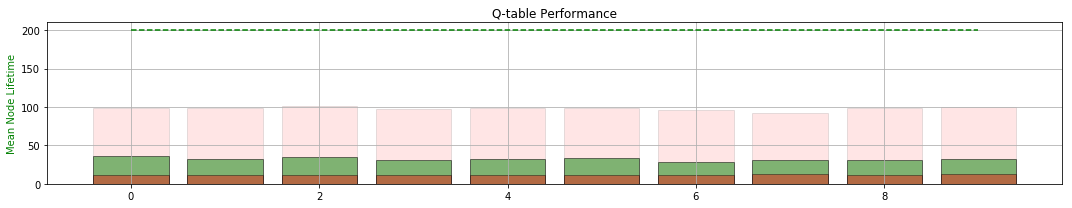

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.624	LOSS : 2.545	LOSS : 2.911	LOSS : 2.894	LOSS : 2.759	LOSS : 2.726	LOSS : 2.659	LOSS : 2.469	LOSS : 2.935	LOSS : 2.762	LOSS : 2.339	LOSS : 2.231	LOSS : 2.682	LOSS : 2.535	LOSS : 2.742	LOSS : 2.985	LOSS : 2.691	LOSS : 2.800	LOSS : 2.827	LOSS : 2.710	LOSS : 2.620	LOSS : 2.523	LOSS : 2.809	LOSS : 2.604	LOSS : 2.654	LOSS : 2.598	LOSS : 2.556	LOSS : 2.788	LOSS : 2.935	LOSS : 2.599	
Validating... MEAN TIME:  97.74
LOSS : 2.847	LOSS : 3.052	LOSS : 2.726	LOSS : 2.751	LOSS : 2.707	LOSS : 2.479	LOSS : 2.825	LOSS : 2.654	LOSS : 2.638	LOSS : 2.869	LOSS : 2.728	LOSS : 3.121	LOSS : 2.552	LOSS : 2.733	LOSS : 3.036	LOSS : 2.334	LOSS : 2.831	LOSS : 2.942	LOSS : 2.840	LOSS : 2.955	LOSS : 2.731	LOSS : 2.779	LOSS : 2.650	LOSS : 2.990	LOSS : 2.566	LOSS : 2.893	LOSS : 3.116	LOSS : 2.788	LOSS : 2.818	LOSS : 2.606	
Validating... MEAN TIME:  97.42
LOSS : 3.021	LOSS : 2.729

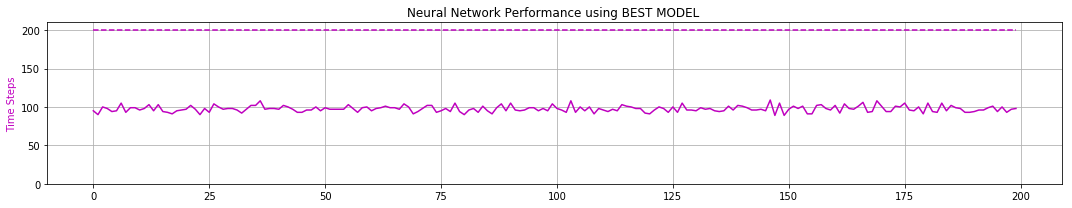

peak memory: 1454.24 MiB, increment: 1016.78 MiB
0 -max- [ 0.202  1.150  0.050  0.616]
0 -min- [-2.398 -3.152 -0.209 -1.657]

1 -max- [ 0.216  1.199  0.049  0.589]
1 -min- [-2.390 -3.278 -0.209 -1.680]

2 -max- [ 0.214  0.940  0.048  0.587]
2 -min- [-2.368 -3.149 -0.209 -1.381]

3 -max- [ 0.205  0.824  0.050  0.678]
3 -min- [-2.385 -3.337 -0.209 -1.375]

4 -max- [ 0.203  1.014  0.048  0.604]
4 -min- [-2.392 -3.335 -0.209 -1.503]

5 -max- [ 0.215  1.017  0.050  0.605]
5 -min- [-2.398 -3.151 -0.209 -1.422]

6 -max- [ 0.207  1.158  0.050  0.598]
6 -min- [-2.373 -3.158 -0.209 -1.676]

7 -max- [ 0.209  0.998  0.056  0.584]
7 -min- [-2.395 -3.268 -0.209 -1.372]

8 -max- [ 0.195  1.153  0.050  0.606]
8 -min- [-2.400 -3.313 -0.209 -1.660]

9 -max- [ 0.207  1.140  0.049  0.610]
9 -min- [-2.398 -3.316 -0.209 -1.655]

Quantization TIME:  0.02 minutes


ITERATION # 29
SMALLEST TIMESTEP in ITERATION 29: 11
REAL TIME TO GENERATE 22085 EXPERIENCES:0:00:00.656687


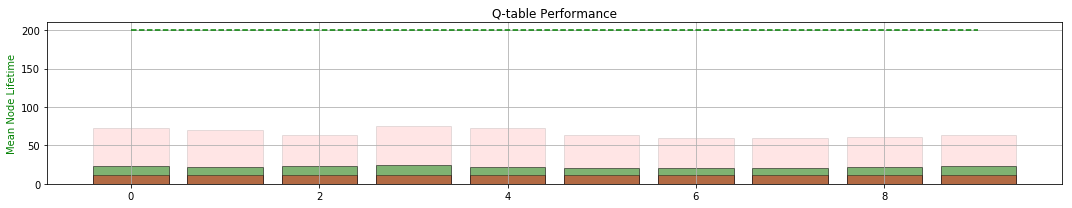

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.050	LOSS : 2.531	LOSS : 2.969	LOSS : 3.052	LOSS : 2.859	LOSS : 2.963	LOSS : 3.279	LOSS : 3.074	LOSS : 2.325	LOSS : 2.593	LOSS : 2.867	LOSS : 2.656	LOSS : 3.065	LOSS : 3.269	LOSS : 2.392	LOSS : 3.028	LOSS : 2.737	LOSS : 2.772	LOSS : 2.576	LOSS : 2.688	LOSS : 2.961	LOSS : 3.101	LOSS : 3.400	LOSS : 2.686	LOSS : 2.640	LOSS : 3.155	LOSS : 3.023	LOSS : 2.916	LOSS : 3.106	LOSS : 2.679	
Validating... MEAN TIME:  98.04
LOSS : 2.867	LOSS : 3.297	LOSS : 2.791	LOSS : 2.806	LOSS : 3.316	LOSS : 2.658	LOSS : 2.598	LOSS : 2.929	LOSS : 2.865	LOSS : 2.777	LOSS : 2.658	LOSS : 2.744	LOSS : 3.058	LOSS : 2.507	LOSS : 2.742	LOSS : 2.595	LOSS : 2.906	LOSS : 2.685	LOSS : 2.437	LOSS : 2.657	LOSS : 2.908	LOSS : 2.722	LOSS : 3.005	LOSS : 2.772	LOSS : 2.911	LOSS : 2.714	LOSS : 2.933	LOSS : 2.934	LOSS : 2.979	LOSS : 3.081	
Validating... MEAN TIME:  96.895
LOSS : 3.014	LOSS : 3.06

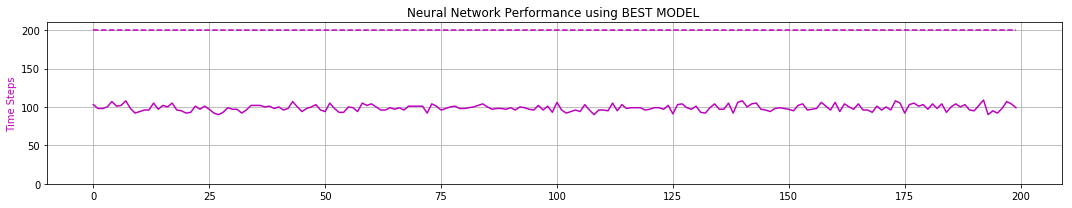

peak memory: 1398.70 MiB, increment: 1031.42 MiB
0 -max- [ 0.203  1.199  0.049  0.587]
0 -min- [-1.081 -2.173 -0.209 -1.680]

1 -max- [ 0.206  0.976  0.048  0.499]
1 -min- [-1.234 -2.420 -0.209 -1.499]

2 -max- [ 0.215  1.011  0.050  0.586]
2 -min- [-0.859 -2.052 -0.209 -1.541]

3 -max- [ 0.201  0.949  0.048  0.624]
3 -min- [-1.130 -2.149 -0.209 -1.422]

4 -max- [ 0.203  1.017  0.050  0.601]
4 -min- [-1.076 -2.221 -0.209 -1.373]

5 -max- [ 0.202  1.158  0.050  0.516]
5 -min- [-0.726 -1.865 -0.209 -1.676]

6 -max- [ 0.203  1.019  0.049  0.588]
6 -min- [-0.613 -1.665 -0.209 -1.702]

7 -max- [ 0.203  1.179  0.050  0.522]
7 -min- [-0.626 -1.850 -0.209 -1.759]

8 -max- [ 0.203  0.835  0.049  0.547]
8 -min- [-0.716 -1.865 -0.209 -1.354]

9 -max- [ 0.199  1.163  0.049  0.452]
9 -min- [-0.791 -1.861 -0.209 -1.660]

Quantization TIME:  0.02 minutes


In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("SMALLEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.min().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    if iteration < 3:
        NN_LR = 1e-4
    else:
        NN_LR = 1e-3
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, -1).astype(np.float16)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  3302.0
Total Serial Timesteps   :  1719383.0
Speed-up                 :  520.71


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  3121 FAILURE  11  30    3302    1719383     520.71
